In [1]:
#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.cluster.hierarchy as sch
from bioinfokit import analys, visuz
from bioinfokit.analys import stat


In [110]:
#Set figure resolution to 300dpi
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(20, 20))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

In [4]:
def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [5]:
ttests=[]
def ttest(df, df_sub1, df_sub2):
    """
    This function takes two subsetted dataframes where
    protein ID's are along the index and the samples
    you are testing are in the columns, and performs a
    ttest to determine whether each protein in the 
    subsets are at different levels. This function
    returns the original dataframe with a new column 
    for the p-value associated with the t-test. 
    equal_var can be set to True or false depending 
    on whether you need to perform welches correction 
    on the data.
    
    parameters
    ----------
    df: pd.DataFrame
    df_sub1: pd.DataFrame
    df_sub2: pd.DataFrame
    
    returns
    -------
    dataframe with p-values
    
    """
    from scipy.stats import ttest_ind
    df_sub1 = df_sub1.transpose() # Transposition is  required
    df_sub2 = df_sub2.transpose()
    ttests = ttest_ind(df_sub1,df_sub2,equal_var=False,
                       nan_policy='omit')
    ttests = ttests.pvalue.transpose() # Transpose the pvalues back to the original orientation.
    df['ttest_pvalue']=ttests
    return df

In [6]:
def fold(df, sub1, sub2, sub1name, sub2name):
    """
    Creates a new column in your dataframe (df) for fold change between
    two sample types (in separate dataframes sub1 and sub2).
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1 : pd.DataFrame
    sub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Newly formed column in your dataframe.
    """
    df['%s Mean' % (sub1name)]=sub1.mean(axis=1,skipna=True)
    df['%s Mean' % (sub2name)]=sub2.mean(axis=1,skipna=True)
    df['Fold Change(%s/%s)' % (sub1name, sub2name)]=df['%s Mean' % (sub1name)]/df['%s Mean' % (sub2name)]
    return df['Fold Change(%s/%s)' % (sub1name, sub2name)]

In [7]:
def piscore(df,sub1name,sub2name):
    """
    pi score is a function which combines outputs from ttest and fold change functions
    and multiplies them to help pick biologically relevant hits within your systems.
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1name : string
    sub2name: string
    
    Returns
    -------
    Newly formed column in your dataframe
    
    
    """
    df['Log2(Fold Change)'] = np.log2(df['Fold Change(%s/%s)'% (sub1name,sub2name)])
    df['-Log(P-value)'] = -np.log10(df['ttest_pvalue'])
    df['%s/%s pi score' % (sub1name,sub2name)] = df['-Log(P-value)']*df['Log2(Fold Change)']
    return df['%s/%s pi score' % (sub1name,sub2name)]

In [8]:
def TwoCategoryMaster(dfmain,dfsub1,dfsub2,sub1name,sub2name):
    """
    This function combines previously created user-defined functions to streamline the data
    analysis.
    
    Parameters
    ----------
    dfmain : pd.DataFrame
    dfsub1 : pd.DataFrame
    dfsub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Updated dataframe
    """
    ttest(dfmain,dfsub1,dfsub2)
    fold(dfmain,dfsub1,dfsub2,sub1name,sub2name)
    piscore(dfmain,sub1name,sub2name)
    return dfmain

In [9]:
#LOAD DATA
df = pd.read_csv('./CSVExport.csv', index_col=0) #This is the txt file output from PD imported as dataframe "df"


In [10]:
df.describe()

OBJECTID  AMA SITE CODE  NATTS Site?   Latitude   Longitude  \
count     71.000000   7.100000e+01    71.000000  71.000000   71.000000   
mean   14949.211268   2.929358e+08     0.394366  37.474581  -92.414371   
std     9097.203041   1.651308e+08     0.492193   6.545663   17.045015   
min       58.000000   1.073550e+07     0.000000  25.892504 -149.824600   
25%     6437.000000   1.313315e+08     0.000000  32.737206  -98.905678   
50%    15542.000000   2.804700e+08     0.000000  38.219158  -85.178726   
75%    23517.000000   4.654300e+08     1.000000  42.216115  -82.732363   
max    29009.000000   5.502700e+08     1.000000  61.205860  -71.082500   

       AQS PARAMETER CODE  Cancer Unit Risk Estimate (1/�g/m3)  \
count                71.0                         7.100000e+01   
mean              17141.0                         3.400000e-05   
std                   0.0                         1.364899e-20   
min               17141.0                         3.400000e-05   
25%               17141.0                         3.400000e-05   
50%               17141.0                         3.400000e-05   
75%               17141.0                         3.400000e-05   
max               17141.0                         3.400000e-05   

       Reference Concentration (mg/m3)  Most RecentYear  \
count                     7.100000e+01        71.000000   
mean                      3.000000e-03      2010.746479   
std                       1.747070e-18         2.791407   
min                       3.000000e-03      2005.000000   
25%                       3.000000e-03      2008.000000   
50%                       3.000000e-03      2012.000000   
75%                       3.000000e-03      2013.000000   
max                       3.000000e-03      2013.000000   

       Recent Year Max Conc (�g/m3)  ...  Toluene (µg/m3)  \
count                     71.000000  ...        71.000000   
mean                       0.312449  ...         3.224649   
std                        0.782293  ...         4.578066   
min                        0.000000  ...         0.235085   
25%                        0.032250  ...         0.840693   
50%                        0.127410  ...         2.124467   
75%                        0.316635  ...         3.476616   
max                        5.734170  ...        30.371022   

       Toxaphene (Chlorinated Camphene) (µg/m3)  Trichloroethylene (µg/m3)  \
count                              6.000000e+00                  71.000000   
mean                               1.100450e-06                   0.016822   
std                                1.839939e-06                   0.022560   
min                                1.603000e-07                   0.000413   
25%                                3.233750e-07                   0.003164   
50%                                3.962000e-07                   0.006530   
75%                                4.754000e-07                   0.019137   
max                                4.849100e-06                   0.091247   

       Triethylamine (µg/m3)  Trifluralin (µg/m3)  Vinyl Acetate (µg/m3)  \
count              71.000000         4.000000e+00              71.000000   
mean                0.001957         1.790710e-03               0.001699   
std                 0.002515         3.168372e-03               0.012012   
min                 0.000057         2.607000e-07               0.000035   
25%                 0.000343         1.694935e-04               0.000042   
50%                 0.001189         3.128230e-04               0.000064   
75%                 0.002602         1.934039e-03               0.000190   
max                 0.014033         6.536932e-03               0.101347   

       Vinyl Bromide (µg/m3)  Vinyl Chloride (µg/m3)  \
count                    0.0               71.000000   
mean                     NaN                0.000709   
std                      NaN                0.001437   
min                      NaN                0.000038   

# 

In [11]:
#Set the max rows displayed in pandas to no max
pd.set_option('display.max_rows', None)

#View all of the different parameters of the whole dataset as rows 
df.transpose()

Row Number                                                                                         1   \
OBJECTID                                                                                           58   
AMA SITE CODE                                                                                20200018   
Location                                                                                          NaN   
STATE                                                                                              AK   
NATTS Site?                                                                                         0   
Latitude                                                                                     61.20586   
Longitude                                                                                   -149.8246   
Type                                                                                         SUBURBAN   
Setting                                                                                           NaN   
NATA HAP Name                                                                             NAPHTHALENE   
AQS PARAMETER CODE                                                                              17141   
AQS PARAMETER NAME                                                    Naphthalene (total tsp & vapor)   
Pollutant Code Description                                                                Naphthalene   
Duration Description                                                                         24 HOURS   
Cancer Unit Risk Estimate (1/�g/m3)                                                          0.000034   
Reference Concentration (mg/m3)                                                                 0.003   
Most RecentYear                                                                                  2013   
Recent Year Max Conc (�g/m3)                                                                  0.31017   
Recent Year Mean Conc (�g/m3)                                                                 0.06392   
Recent Year Median Conc (�g/m3)                                                               0.04577   
Recent Year Variance                                                                          0.00368   
Recent Year Mean MDL Conc (�g/m3)                                                             0.00024   
Recent Year Percent Less Than MDL                                                                   0   
Recent Year Daily Count                                                                            62   
Recent Year Mean Risk (in a million)                                                             2.17   
Recent Year Median Risk (in a million)                                                           1.56   
Recent Year Mean MDL Risk (in a million)                                                         0.01   
Recent Year Mean HQ                                                                              0.02   
Recent Year Median HQ                                                                            0.02   
Recent Year Mean MDL HQ                                                                           0.0   
Years Monitored                                                                                     2   
Trends Plot                                         https://gispub.epa.gov/NATA/Trendplots/boxplot...   
intersected                                                                                        In   
GLProcessed                                                                                       NaN   
STCOFIPS                                                                                         2020   
State                                                                                              AK   
County                                                                         Anchorage Municipality   
FIPS      

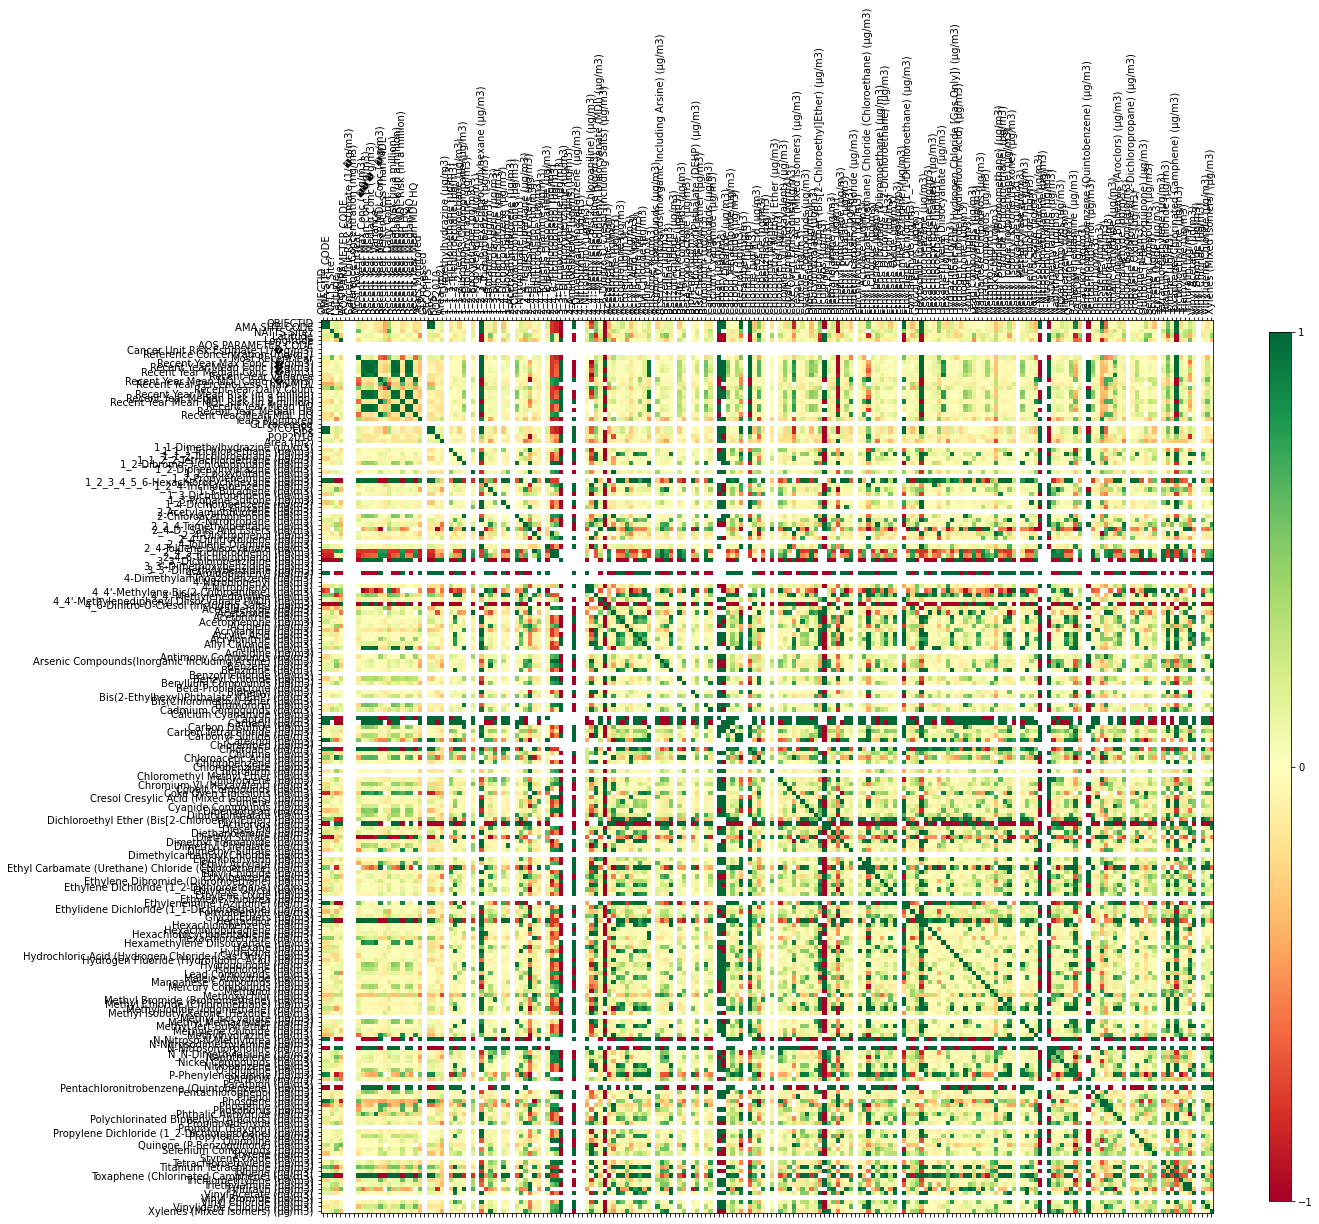

In [12]:
#See what the data looks like in its current form
plot_corr(df)

In [13]:
#Set the max rows displayed in pandas to 10
pd.set_option('display.max_rows', 10)


In [14]:
dft = df.transpose()
dft

Row Number                             1         2            3   \
OBJECTID                               58       184          617   
AMA SITE CODE                    20200018  10735503     40139997   
Location                              NaN       NaN  Phoenix, AZ   
STATE                                  AK        AL           AZ   
NATTS Site?                             0         0            1   
...                                   ...       ...          ...   
Vinyl Acetate (µg/m3)            0.000064  0.000046     0.000115   
Vinyl Bromide (µg/m3)                 NaN       NaN          NaN   
Vinyl Chloride (µg/m3)           0.000116  0.000492     0.000038   
Vinylidene Chloride (µg/m3)      0.000003  0.000269     0.000003   
Xylenes (Mixed Isomers) (µg/m3)  2.273865  1.157399     1.555841   

Row Number                                    4             5             6   \
OBJECTID                                    2191          2836          3629   
AMA SITE CODE                           60371103      60658001      60850005   
Location                         Los Angeles, CA  Rubidoux, CA  San Jose, CA   
STATE                                         CA            CA            CA   
NATTS Site?                                    1             1             1   
...                                          ...           ...           ...   
Vinyl Acetate (µg/m3)                   0.000584      0.000136      0.004423   
Vinyl Bromide (µg/m3)                        NaN           NaN           NaN   
Vinyl Chloride (µg/m3)                  0.000323      0.000292      0.002786   
Vinylidene Chloride (µg/m3)             0.000018      0.000002      0.000086   
Xylenes (Mixed Isomers) (µg/m3)         2.675677        1.4088      2.238695   

Row Number                                          7               8   \
OBJECTID                                          4411            4624   
AMA SITE CODE                                 80770018       110010043   
Location                         Grand Junction, CO-18  Washington, DC   
STATE                                               CO              DC   
NATTS Site?                                          1               1   
...                                                ...             ...   
Vinyl Acetate (µg/m3)                         0.000035        0.000183   
Vinyl Bromide (µg/m3)                              NaN             NaN   
Vinyl Chloride (µg/m3)                        0.000543        0.000354   
Vinylidene Chloride (µg/m3)                        NaN        0.000159   
Xylenes (Mixed Isomers) (µg/m3)               0.712528        2.209622   

Row Number                              9                    10  ...  \
OBJECTID                              5393                 5693  ...   
AMA SITE CODE                    120573002            121030026  ...   
Location                         Tampa, FL  Pinellas County, FL  ...   
STATE                                   FL                   FL  ...   
NATTS Site?                              1                    1  ...   
...                                    ...                  ...  ...   
Vinyl Acetate (µg/m3)             0.000041             0.000064  ...   
Vinyl Bromide (µg/m3)                  NaN                  NaN  ...   
Vinyl Chloride (µg/m3)            0.000205             0.005374  ...   
Vinylidene Chloride (µg/m3)       0.000004             0.000041  ...   
Xylenes (Mixed Isomers) (µg/m3)    0.76214             1.372637  ...   

Row Number                              62             63            64  \
OBJECTID                             26940          27060         27370   
AMA SITE CODE                    484790016      490110004     510870014   
Location                               NaN  Bountiful, UT  Richmond, VA   
STATE                                   TX             UT            VA   
NATTS Site?                              0              1             1   
...               

In [15]:
#drop missing values 
dfd = dft.dropna()
dfd

Row Number                             1          2          3         4   \
OBJECTID                               58        184        617      2191   
AMA SITE CODE                    20200018   10735503   40139997  60371103   
STATE                                  AK         AL         AZ        CA   
NATTS Site?                             0          0          1         1   
Latitude                         61.20586  33.568401  33.503731  34.06659   
...                                   ...        ...        ...       ...   
Trichloroethylene (µg/m3)        0.009107   0.031461   0.001794  0.091247   
Triethylamine (µg/m3)            0.001888   0.001022   0.002885  0.002611   
Vinyl Acetate (µg/m3)            0.000064   0.000046   0.000115  0.000584   
Vinyl Chloride (µg/m3)           0.000116   0.000492   0.000038  0.000323   
Xylenes (Mixed Isomers) (µg/m3)  2.273865   1.157399   1.555841  2.675677   

Row Number                             5          6         7          8   \
OBJECTID                             2836       3629      4411       4624   
AMA SITE CODE                    60658001   60850005  80770018  110010043   
STATE                                  CA         CA        CO         DC   
NATTS Site?                             1          1         1          1   
Latitude                         33.99958  37.348497  39.06425  38.921847   
...                                   ...        ...       ...        ...   
Trichloroethylene (µg/m3)        0.043902   0.084937  0.000413   0.007729   
Triethylamine (µg/m3)            0.001325   0.001901  0.000436   0.002597   
Vinyl Acetate (µg/m3)            0.000136   0.004423  0.000035   0.000183   
Vinyl Chloride (µg/m3)           0.000292   0.002786  0.000543   0.000354   
Xylenes (Mixed Isomers) (µg/m3)    1.4088   2.238695  0.712528   2.209622   

Row Number                              9          10  ...         62  \
OBJECTID                              5393       5693  ...      26940   
AMA SITE CODE                    120573002  121030026  ...  484790016   
STATE                                   FL         FL  ...         TX   
NATTS Site?                              1          1  ...          0   
Latitude                          27.96565  27.850041  ...  27.511267   
...                                    ...        ...  ...        ...   
Trichloroethylene (µg/m3)         0.000532   0.004724  ...     0.0042   
Triethylamine (µg/m3)              0.00062   0.002122  ...   0.000438   
Vinyl Acetate (µg/m3)             0.000041   0.000064  ...   0.000039   
Vinyl Chloride (µg/m3)            0.000205   0.005374  ...   0.000042   
Xylenes (Mixed Isomers) (µg/m3)    0.76214   1.372637  ...   0.283549   

Row Number                              63         64         65         66  \
OBJECTID                             27060      27370      27862      28358   
AMA SITE CODE                    490110004  510870014  500070007  530330057   
STATE                                   UT         VA         VT         WA   
NATTS Site?                              1          1          1          0   
Latitude                         40.902967   37.55655   44.52839   47.55975   
...                                    ...        ...        ...        ...   
Trichloroethylene (µg/m3)         0.003379    0.00888   0.001364   0.037683   
Triethylamine (µg/m3)             0.002608   0.001828   0.000061   0.005738   
Vinyl Acetate (µg/m3)              0.00008   0.000073   0.000065   0.000076   
Vinyl Chloride (µg/m3)            0.000209   0.000279   0.000183   0.000085   
Xylenes (Mixed Isomers) (µg/m3)   1.395236   1.249541   0.122542   6.003308   

Row Number                              67         68         69         70  \
OBJECTID                             28435      28553      28618      28939   
AMA SITE CODE                    530330080  530530029  530530031  550270001   
STATE                                   WA         WA         WA         WI   
NATTS Si

In [16]:
#set the state row as the column titles
dfd.columns = dfd.iloc[2]
dfd


STATE                                  AK         AL         AZ        CA  \
OBJECTID                               58        184        617      2191   
AMA SITE CODE                    20200018   10735503   40139997  60371103   
STATE                                  AK         AL         AZ        CA   
NATTS Site?                             0          0          1         1   
Latitude                         61.20586  33.568401  33.503731  34.06659   
...                                   ...        ...        ...       ...   
Trichloroethylene (µg/m3)        0.009107   0.031461   0.001794  0.091247   
Triethylamine (µg/m3)            0.001888   0.001022   0.002885  0.002611   
Vinyl Acetate (µg/m3)            0.000064   0.000046   0.000115  0.000584   
Vinyl Chloride (µg/m3)           0.000116   0.000492   0.000038  0.000323   
Xylenes (Mixed Isomers) (µg/m3)  2.273865   1.157399   1.555841  2.675677   

STATE                                  CA         CA        CO         DC  \
OBJECTID                             2836       3629      4411       4624   
AMA SITE CODE                    60658001   60850005  80770018  110010043   
STATE                                  CA         CA        CO         DC   
NATTS Site?                             1          1         1          1   
Latitude                         33.99958  37.348497  39.06425  38.921847   
...                                   ...        ...       ...        ...   
Trichloroethylene (µg/m3)        0.043902   0.084937  0.000413   0.007729   
Triethylamine (µg/m3)            0.001325   0.001901  0.000436   0.002597   
Vinyl Acetate (µg/m3)            0.000136   0.004423  0.000035   0.000183   
Vinyl Chloride (µg/m3)           0.000292   0.002786  0.000543   0.000354   
Xylenes (Mixed Isomers) (µg/m3)    1.4088   2.238695  0.712528   2.209622   

STATE                                   FL         FL  ...         TX  \
OBJECTID                              5393       5693  ...      26940   
AMA SITE CODE                    120573002  121030026  ...  484790016   
STATE                                   FL         FL  ...         TX   
NATTS Site?                              1          1  ...          0   
Latitude                          27.96565  27.850041  ...  27.511267   
...                                    ...        ...  ...        ...   
Trichloroethylene (µg/m3)         0.000532   0.004724  ...     0.0042   
Triethylamine (µg/m3)              0.00062   0.002122  ...   0.000438   
Vinyl Acetate (µg/m3)             0.000041   0.000064  ...   0.000039   
Vinyl Chloride (µg/m3)            0.000205   0.005374  ...   0.000042   
Xylenes (Mixed Isomers) (µg/m3)    0.76214   1.372637  ...   0.283549   

STATE                                   UT         VA         VT         WA  \
OBJECTID                             27060      27370      27862      28358   
AMA SITE CODE                    490110004  510870014  500070007  530330057   
STATE                                   UT         VA         VT         WA   
NATTS Site?                              1          1          1          0   
Latitude                         40.902967   37.55655   44.52839   47.55975   
...                                    ...        ...        ...        ...   
Trichloroethylene (µg/m3)         0.003379    0.00888   0.001364   0.037683   
Triethylamine (µg/m3)             0.002608   0.001828   0.000061   0.005738   
Vinyl Acetate (µg/m3)              0.00008   0.000073   0.000065   0.000076   
Vinyl Chloride (µg/m3)            0.000209   0.000279   0.000183   0.000085   
Xylenes (Mixed Isomers) (µg/m3)   1.395236   1.249541   0.122542   6.003308   

STATE                                   WA         WA         WA         WI  \
OBJECTID                             28435      28553      28618      28939   
AMA SITE CODE                    530330080  530530029  530530031  550270001   
STATE                                   WA         WA         WA         WI   
NATTS Si

In [17]:
#transpose the data which makes state the index column
dfdt = dfd.transpose()
dfdt

OBJECTID AMA SITE CODE STATE NATTS Site?   Latitude   Longitude  \
STATE                                                                   
AK          58      20200018    AK           0   61.20586   -149.8246   
AL         184      10735503    AL           0  33.568401  -86.802902   
AZ         617      40139997    AZ           1  33.503731 -112.095809   
CA        2191      60371103    CA           1   34.06659  -118.22688   
CA        2836      60658001    CA           1   33.99958  -117.41601   
...        ...           ...   ...         ...        ...         ...   
WA       28435     530330080    WA           1  47.568333 -122.308056   
WA       28553     530530029    WA           0  47.186401 -122.451698   
WA       28618     530530031    WA           0  47.265598 -122.385803   
WI       28939     550270001    WI           1  43.466111  -88.621111   
WI       29009     550270007    WI           1     43.435  -88.527778   

                        Type NATA HAP Name AQS PARAMETER CODE  \
STATE                                                           
AK                  SUBURBAN   NAPHTHALENE              17141   
AL     URBAN AND CENTER CITY   NAPHTHALENE              17141   
AZ     URBAN AND CENTER CITY   NAPHTHALENE              17141   
CA     URBAN AND CENTER CITY   NAPHTHALENE              17141   
CA                  SUBURBAN   NAPHTHALENE              17141   
...                      ...           ...                ...   
WA     URBAN AND CENTER CITY   NAPHTHALENE              17141   
WA                  SUBURBAN   NAPHTHALENE              17141   
WA                  SUBURBAN   NAPHTHALENE              17141   
WI                     RURAL   NAPHTHALENE              17141   
WI                     RURAL   NAPHTHALENE              17141   

                    AQS PARAMETER NAME  ...  \
STATE                                   ...   
AK     Naphthalene (total tsp & vapor)  ...   
AL     Naphthalene (total tsp & vapor)  ...   
AZ     Naphthalene (total tsp & vapor)  ...   
CA     Naphthalene (total tsp & vapor)  ...   
CA     Naphthalene (total tsp & vapor)  ...   
...                                ...  ...   
WA     Naphthalene (total tsp & vapor)  ...   
WA     Naphthalene (total tsp & vapor)  ...   
WA     Naphthalene (total tsp & vapor)  ...   
WI     Naphthalene (total tsp & vapor)  ...   
WI     Naphthalene (total tsp & vapor)  ...   

      Propylene Dichloride (1_2-Dichloropropane) (µg/m3)  \
STATE                                                      
AK                                              0.000286   
AL                                              0.000068   
AZ                                              0.000005   
CA                                              0.000017   
CA                                              0.000013   
...                                                  ...   
WA                                               0.00002   
WA                                               0.00005   
WA                                              0.000084   
WI                                              0.000015   
WI                                              0.000012   

      Selenium Compounds (µg/m3) Styrene (µg/m3) Tetrachloroethylene (µg/m3)  \
STATE                                                                          
AK                      0.001009        0.038551                    0.031786   
AL                      0.000286        0.023536                    0.049028   
AZ                      0.000204        0.034803                    0.143608   
CA                       0.00029         0.04077                     0.88772   
CA                      0.000298        0.030017                    0.392185   
...                          ...             ...                         ...   
WA                      0.000801         0.03135                    0.229332   
WA                      0.000208        0.037277                    0.085374   
WA               

In [18]:
#remove columns that are not float (remove non-numeric values)
cols_to_remove = []

for col in dfdt.columns:
    try:
        _ = dfdt[col].astype(float)
    except ValueError:
        print('Couldn\'t covert %s to float - removed the column' % col)
        cols_to_remove.append(col)
        pass

# keep only the columns in df that do not contain string
dfdtn = dfdt[[col for col in dfdt.columns if col not in cols_to_remove]]

Couldn't covert STATE to float - removed the column
Couldn't covert Type to float - removed the column
Couldn't covert NATA HAP Name to float - removed the column
Couldn't covert AQS PARAMETER NAME to float - removed the column
Couldn't covert Pollutant Code Description to float - removed the column
Couldn't covert Duration Description to float - removed the column
Couldn't covert Trends Plot to float - removed the column
Couldn't covert intersected to float - removed the column
Couldn't covert State to float - removed the column
Couldn't covert County to float - removed the column


In [19]:
dfdtn

OBJECTID AMA SITE CODE NATTS Site?   Latitude   Longitude  \
STATE                                                             
AK          58      20200018           0   61.20586   -149.8246   
AL         184      10735503           0  33.568401  -86.802902   
AZ         617      40139997           1  33.503731 -112.095809   
CA        2191      60371103           1   34.06659  -118.22688   
CA        2836      60658001           1   33.99958  -117.41601   
...        ...           ...         ...        ...         ...   
WA       28435     530330080           1  47.568333 -122.308056   
WA       28553     530530029           0  47.186401 -122.451698   
WA       28618     530530031           0  47.265598 -122.385803   
WI       28939     550270001           1  43.466111  -88.621111   
WI       29009     550270007           1     43.435  -88.527778   

      AQS PARAMETER CODE Cancer Unit Risk Estimate (1/�g/m3)  \
STATE                                                          
AK                 17141                            0.000034   
AL                 17141                            0.000034   
AZ                 17141                            0.000034   
CA                 17141                            0.000034   
CA                 17141                            0.000034   
...                  ...                                 ...   
WA                 17141                            0.000034   
WA                 17141                            0.000034   
WA                 17141                            0.000034   
WI                 17141                            0.000034   
WI                 17141                            0.000034   

      Reference Concentration (mg/m3) Most RecentYear  \
STATE                                                   
AK                              0.003            2013   
AL                              0.003            2012   
AZ                              0.003            2013   
CA                              0.003            2013   
CA                              0.003            2013   
...                               ...             ...   
WA                              0.003            2013   
WA                              0.003            2009   
WA                              0.003            2009   
WI                              0.003            2013   
WI                              0.003            2009   

      Recent Year Max Conc (�g/m3)  ...  \
STATE                               ...   
AK                         0.31017  ...   
AL                         5.73417  ...   
AZ                         0.28489  ...   
CA                         0.34986  ...   
CA                         0.40488  ...   
...                            ...  ...   
WA                         0.21363  ...   
WA                         0.57627  ...   
WA                         0.41088  ...   
WI                         0.04669  ...   
WI                         0.11859  ...   

      Propylene Dichloride (1_2-Dichloropropane) (µg/m3)  \
STATE                                                      
AK                                              0.000286   
AL                                              0.000068   
AZ                                              0.000005   
CA                                              0.000017   
CA                                              0.000013   
...                                                  ...   
WA                                               0.00002   
WA                                               0.00005   
WA                                              0.000084   
WI                                              0.000015   
WI                                              0.000012   

      Selenium Compounds (µg/m3) Styrene (µg/m3) Tetrachloroethylene (µg/m3)  \
STATE                                                                          
AK                      0.001009        0.038551          

In [20]:
#transpose the data back to the states being the column titles
df_cool = dfdtn.transpose()
df_cool

STATE                                  AK         AL          AZ         CA  \
OBJECTID                               58        184         617       2191   
AMA SITE CODE                    20200018   10735503    40139997   60371103   
NATTS Site?                             0          0           1          1   
Latitude                         61.20586  33.568401   33.503731   34.06659   
Longitude                       -149.8246 -86.802902 -112.095809 -118.22688   
...                                   ...        ...         ...        ...   
Trichloroethylene (µg/m3)        0.009107   0.031461    0.001794   0.091247   
Triethylamine (µg/m3)            0.001888   0.001022    0.002885   0.002611   
Vinyl Acetate (µg/m3)            0.000064   0.000046    0.000115   0.000584   
Vinyl Chloride (µg/m3)           0.000116   0.000492    0.000038   0.000323   
Xylenes (Mixed Isomers) (µg/m3)  2.273865   1.157399    1.555841   2.675677   

STATE                                   CA          CA          CO         DC  \
OBJECTID                              2836        3629        4411       4624   
AMA SITE CODE                     60658001    60850005    80770018  110010043   
NATTS Site?                              1           1           1          1   
Latitude                          33.99958   37.348497    39.06425  38.921847   
Longitude                       -117.41601 -121.894898 -108.561605 -77.013178   
...                                    ...         ...         ...        ...   
Trichloroethylene (µg/m3)         0.043902    0.084937    0.000413   0.007729   
Triethylamine (µg/m3)             0.001325    0.001901    0.000436   0.002597   
Vinyl Acetate (µg/m3)             0.000136    0.004423    0.000035   0.000183   
Vinyl Chloride (µg/m3)            0.000292    0.002786    0.000543   0.000354   
Xylenes (Mixed Isomers) (µg/m3)     1.4088    2.238695    0.712528   2.209622   

STATE                                   FL         FL  ...         TX  \
OBJECTID                              5393       5693  ...      26940   
AMA SITE CODE                    120573002  121030026  ...  484790016   
NATTS Site?                              1          1  ...          0   
Latitude                          27.96565  27.850041  ...  27.511267   
Longitude                         -82.2304  -82.71459  ... -99.520287   
...                                    ...        ...  ...        ...   
Trichloroethylene (µg/m3)         0.000532   0.004724  ...     0.0042   
Triethylamine (µg/m3)              0.00062   0.002122  ...   0.000438   
Vinyl Acetate (µg/m3)             0.000041   0.000064  ...   0.000039   
Vinyl Chloride (µg/m3)            0.000205   0.005374  ...   0.000042   
Xylenes (Mixed Isomers) (µg/m3)    0.76214   1.372637  ...   0.283549   

STATE                                    UT         VA         VT          WA  \
OBJECTID                              27060      27370      27862       28358   
AMA SITE CODE                     490110004  510870014  500070007   530330057   
NATTS Site?                               1          1          1           0   
Latitude                          40.902967   37.55655   44.52839    47.55975   
Longitude                       -111.884467 -77.400411  -72.86884 -122.338265   
...                                     ...        ...        ...         ...   
Trichloroethylene (µg/m3)          0.003379    0.00888   0.001364    0.037683   
Triethylamine (µg/m3)              0.002608   0.001828   0.000061    0.005738   
Vinyl Acetate (µg/m3)               0.00008   0.000073   0.000065    0.000076   
Vinyl Chloride (µg/m3)             0.000209   0.000279   0.000183    0.000085   
Xylenes (Mixed Isomers) (µg/m3)    1.395236   1.249541   0.122542    6.003308   

STATE                                    WA          WA          WA  \
OBJECTID                              28435       28553       28618   
AMA SITE CODE                     530330080   530530029   530530031   
NATTS Site?    

In [21]:
#Export dataframe to csv with index
df_cool.to_csv(r'./chemicalsbystate_nontransformed.csv')

In [89]:
# load data file
df_b = pd.read_excel (r'chemicalsbystate_nontransformed.xlsx', index_col=0)
df_b.head(10)

AK        AL        AZ        CA  \
Chemical                                                                       
1_1_1-Trichloroethane (¬µg/m3)        0.071949  0.063815  0.080853  0.077393   
1_1_2-Trichloroethane (¬µg/m3)        0.000386  0.000413  0.000386  0.000397   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000840  0.000199  0.000018  0.000123   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  0.000001  0.000001   
1_3-Butadiene (¬µg/m3)                0.197509  0.065719  0.075517  0.110161   
1_3-Dichloropropene (¬µg/m3)          0.000623  0.000084  0.000163  0.032852   
1_4-Dichlorobenzene (¬µg/m3)          0.009270  0.000302  0.000836  0.272366   
2_2_4-Trimethylpentane (¬µg/m3)       1.067067  0.371113  0.703446  0.892935   
Acetaldehyde (¬µg/m3)                 0.426471  3.274960  3.103408  2.177506   
Acetonitrile (¬µg/m3)                 0.170003  0.170001  0.170002  0.170012   

                                          CA.1      CA.2        CO        DC  \
Chemical                                                                       
1_1_1-Trichloroethane (¬µg/m3)        0.064345  4.506996  0.060000  0.160085   
1_1_2-Trichloroethane (¬µg/m3)        0.000387  0.000386  0.000387  0.000387   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000089  0.000178  0.000227  0.000063   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  0.000001  0.000001   
1_3-Butadiene (¬µg/m3)                0.053473  0.102434  0.056482  0.147935   
1_3-Dichloropropene (¬µg/m3)          0.017076  0.015403  0.000068  0.075156   
1_4-Dichlorobenzene (¬µg/m3)          0.144954  0.170401  0.000722  0.027725   
2_2_4-Trimethylpentane (¬µg/m3)       0.428733  0.887912  0.326326  0.818662   
Acetaldehyde (¬µg/m3)                 1.894765  1.704062  1.598139  2.593681   
Acetonitrile (¬µg/m3)                 0.170000  0.170874  0.170000  0.170130   

                                            FL      FL.1  ...      TX.8  \
Chemical                                                  ...             
1_1_1-Trichloroethane (¬µg/m3)        0.062125  0.071878  ...  0.061450   
1_1_2-Trichloroethane (¬µg/m3)        0.000386  0.000386  ...  0.000391   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000076  0.001527  ...  0.000003   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  ...  0.000001   
1_3-Butadiene (¬µg/m3)                0.039993  0.070932  ...  0.015150   
1_3-Dichloropropene (¬µg/m3)          0.001161  0.000058  ...  0.000024   
1_4-Dichlorobenzene (¬µg/m3)          0.000098  0.000368  ...  0.000161   
2_2_4-Trimethylpentane (¬µg/m3)       0.288708  0.655704  ...  0.352714   
Acetaldehyde (¬µg/m3)                 2.551728  2.013978  ...  1.810173   
Acetonitrile (¬µg/m3)                 0.170001  0.170000  ...  0.170000   

                                            UT        VA        VT        WA  \
Chemical                                                                       
1_1_1-Trichloroethane (¬µg/m3)        0.078940  0.075399  0.060016  0.068520   
1_1_2-Trichloroethane (¬µg/m3)        0.000386  0.000387  0.000386  0.000387   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000091  0.000113  0.000068  0.000032   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  0.000001  0.000001   
1_3-Butadiene (¬µg/m3)                0.081834  0.105447  0.009468  0.312107   
1_3-Dichloropropene (¬µg/m3)          0.000178  0.002316  0.000280  0.000052   
1_4-Dichlorobenzene (¬µg/m3)          0.001174  0.001394  0.000503  0.000088   
2_2_4-Trimethylpentane (¬µg/m3)       0.562898  0.394020  0.125107  0.788677   
Acetaldehyde (¬µg/m3)                 1.359291  2.756710  1.075297  3.090711   
Acetonitrile (¬µg/m3)                 0.170003  0.170120  0.170005  0.170120   

                                          WA.1      WA.2      WA.3        WI  \
Chemical                                                                       
1_1_1-Trichloroethane (¬µg/m3)        0.069604  0.073308  0.068299  0.060915   
1_1_2-Trichloroethan

# ANOVA Analysis - non-transformed

In [90]:
# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(df_b.reset_index(), id_vars=['Chemical'], value_vars=['AK', 'AL', 'AZ', 'CA', 'CO', 'DC', 'FL','GA', 'IL', 'KY','MA','MI','MO', 'MS', 'NJ', 'NY', 'OH', 'OR', 'RI', 'SC', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI'])


In [91]:
# replace column names
df_melt.columns = ['index', 'group', 'value']
df_melt

index group         value
0                        1_1_1-Trichloroethane (¬µg/m3)    AK  7.194874e-02
1                        1_1_2-Trichloroethane (¬µg/m3)    AK  3.861729e-04
2                    1_1_2_2-Tetrachloroethane (¬µg/m3)    AK  8.396811e-04
3                  1_2-Dibromo-3-Chloropropane (¬µg/m3)    AK  1.313100e-06
4                                1_3-Butadiene (¬µg/m3)    AK  1.975087e-01
5                          1_3-Dichloropropene (¬µg/m3)    AK  6.230824e-04
6                          1_4-Dichlorobenzene (¬µg/m3)    AK  9.270202e-03
7                       2_2_4-Trimethylpentane (¬µg/m3)    AK  1.067067e+00
8                                 Acetaldehyde (¬µg/m3)    AK  4.264712e-01
9                                 Acetonitrile (¬µg/m3)    AK  1.700028e-01
10                                    Acrolein (¬µg/m3)    AK  5.155530e-02
11                               Acrylonitrile (¬µg/m3)    AK  3.262962e-04
12                          Antimony Compounds (¬µg/m3)    AK  6.567400e-05
13    Arsenic Compounds(Inorganic Including Arsine) ...    AK  4.143871e-04
14                                     Benzene (¬µg/m3)    AK  1.472759e+00
15                                   Benzidine (¬µg/m3)    AK  2.460000e-08
16                             Benzyl Chloride (¬µg/m3)    AK  1.440457e-04
17                         Beryllium Compounds (¬µg/m3)    AK  1.705623e-04
18                                    Biphenyl (¬µg/m3)    AK  5.775330e-05
19           Bis(2-Ethylhexyl)Phthalate (DEHP) (¬µg/m3)    AK  5.927282e-03
20                                   Bromoform (¬µg/m3)    AK  1.000004e-02
21                           Cadmium Compounds (¬µg/m3)    AK  2.038788e-04
22                            Carbon Disulfide (¬µg/m3)    AK  5.497109e-03
23                        Carbon Tetrachloride (¬µg/m3)    AK  5.470092e-01
24                               Chlorobenzene (¬µg/m3)    AK  2.953703e-04
25                                  Chloroform (¬µg/m3)    AK  5.805303e-02
26                    Chromium VI (Hexavalent) (¬µg/m3)    AK  9.481200e-06
27                            Cobalt Compounds (¬µg/m3)    AK  4.975060e-05
28        Cresol Cresylic Acid (Mixed Isomers) (¬µg/m3)    AK  2.410268e-02
29                                      Cumene (¬µg/m3)    AK  1.316242e-03
30                           Cyanide Compounds (¬µg/m3)    AK  1.791784e-04
31                            Dibutylphthalate (¬µg/m3)    AK  6.418460e-05
32                                   Diesel PM (¬µg/m3)    AK  9.223155e-01
33                              Ethyl Acrylate (¬µg/m3)    AK  7.769110e-05
34                                Ethylbenzene (¬µg/m3)    AK  6.212990e-01
35          Ethylene Dibromide (Dibromoethane) (¬µg/m3)    AK  1.888140e-04
36    Ethylene Dichloride (1_2-Dichloroethane) (¬µg/m3)    AK  2.355122e-03
37                             Ethylene Glycol (¬µg/m3)    AK  5.040870e-01
38                              Ethylene Oxide (¬µg/m3)    AK  3.443163e-04
39                                Formaldehyde (¬µg/m3)    AK  7.412684e-01
40                               Glycol Ethers (¬µg/m3)    AK  2.246990e-02
41                  Hexamethylene Diisocyanate (¬µg/m3)    AK  5.700000e-08
42                                      Hexane (¬µg/m3)    AK  1.693859e+00
43    Hydrochloric Acid (Hydrogen Chloride [Gas Only...    AK  1.887848e-03
44       Hydrogen Fluoride (Hydrofluoric Acid) (¬µg/m3)    AK  1.381658e-04
45                              Lead Compounds (¬µg/m3)    AK  9.578286e-03
46                         Manganese Compounds (¬µg/m3)    AK  6.720386e-04
47                           Mercury Compounds (¬µg/m3)    AK  3.029664e-04
48                                    Methanol (¬µg/m3)    AK  1.409232e+00
49               Methyl Bromide (Bromomethane) (¬µg/m3)    AK  2.940015e-02
50             Methyl Chloride (Chloromethane) (¬µg/m3)    AK  1.090000e+00
51             Methyl Isobutyl Ketone (Hexone) (¬µg/m3)    AK  1.741322e-01
52                    

/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 78.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 75.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 80.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot

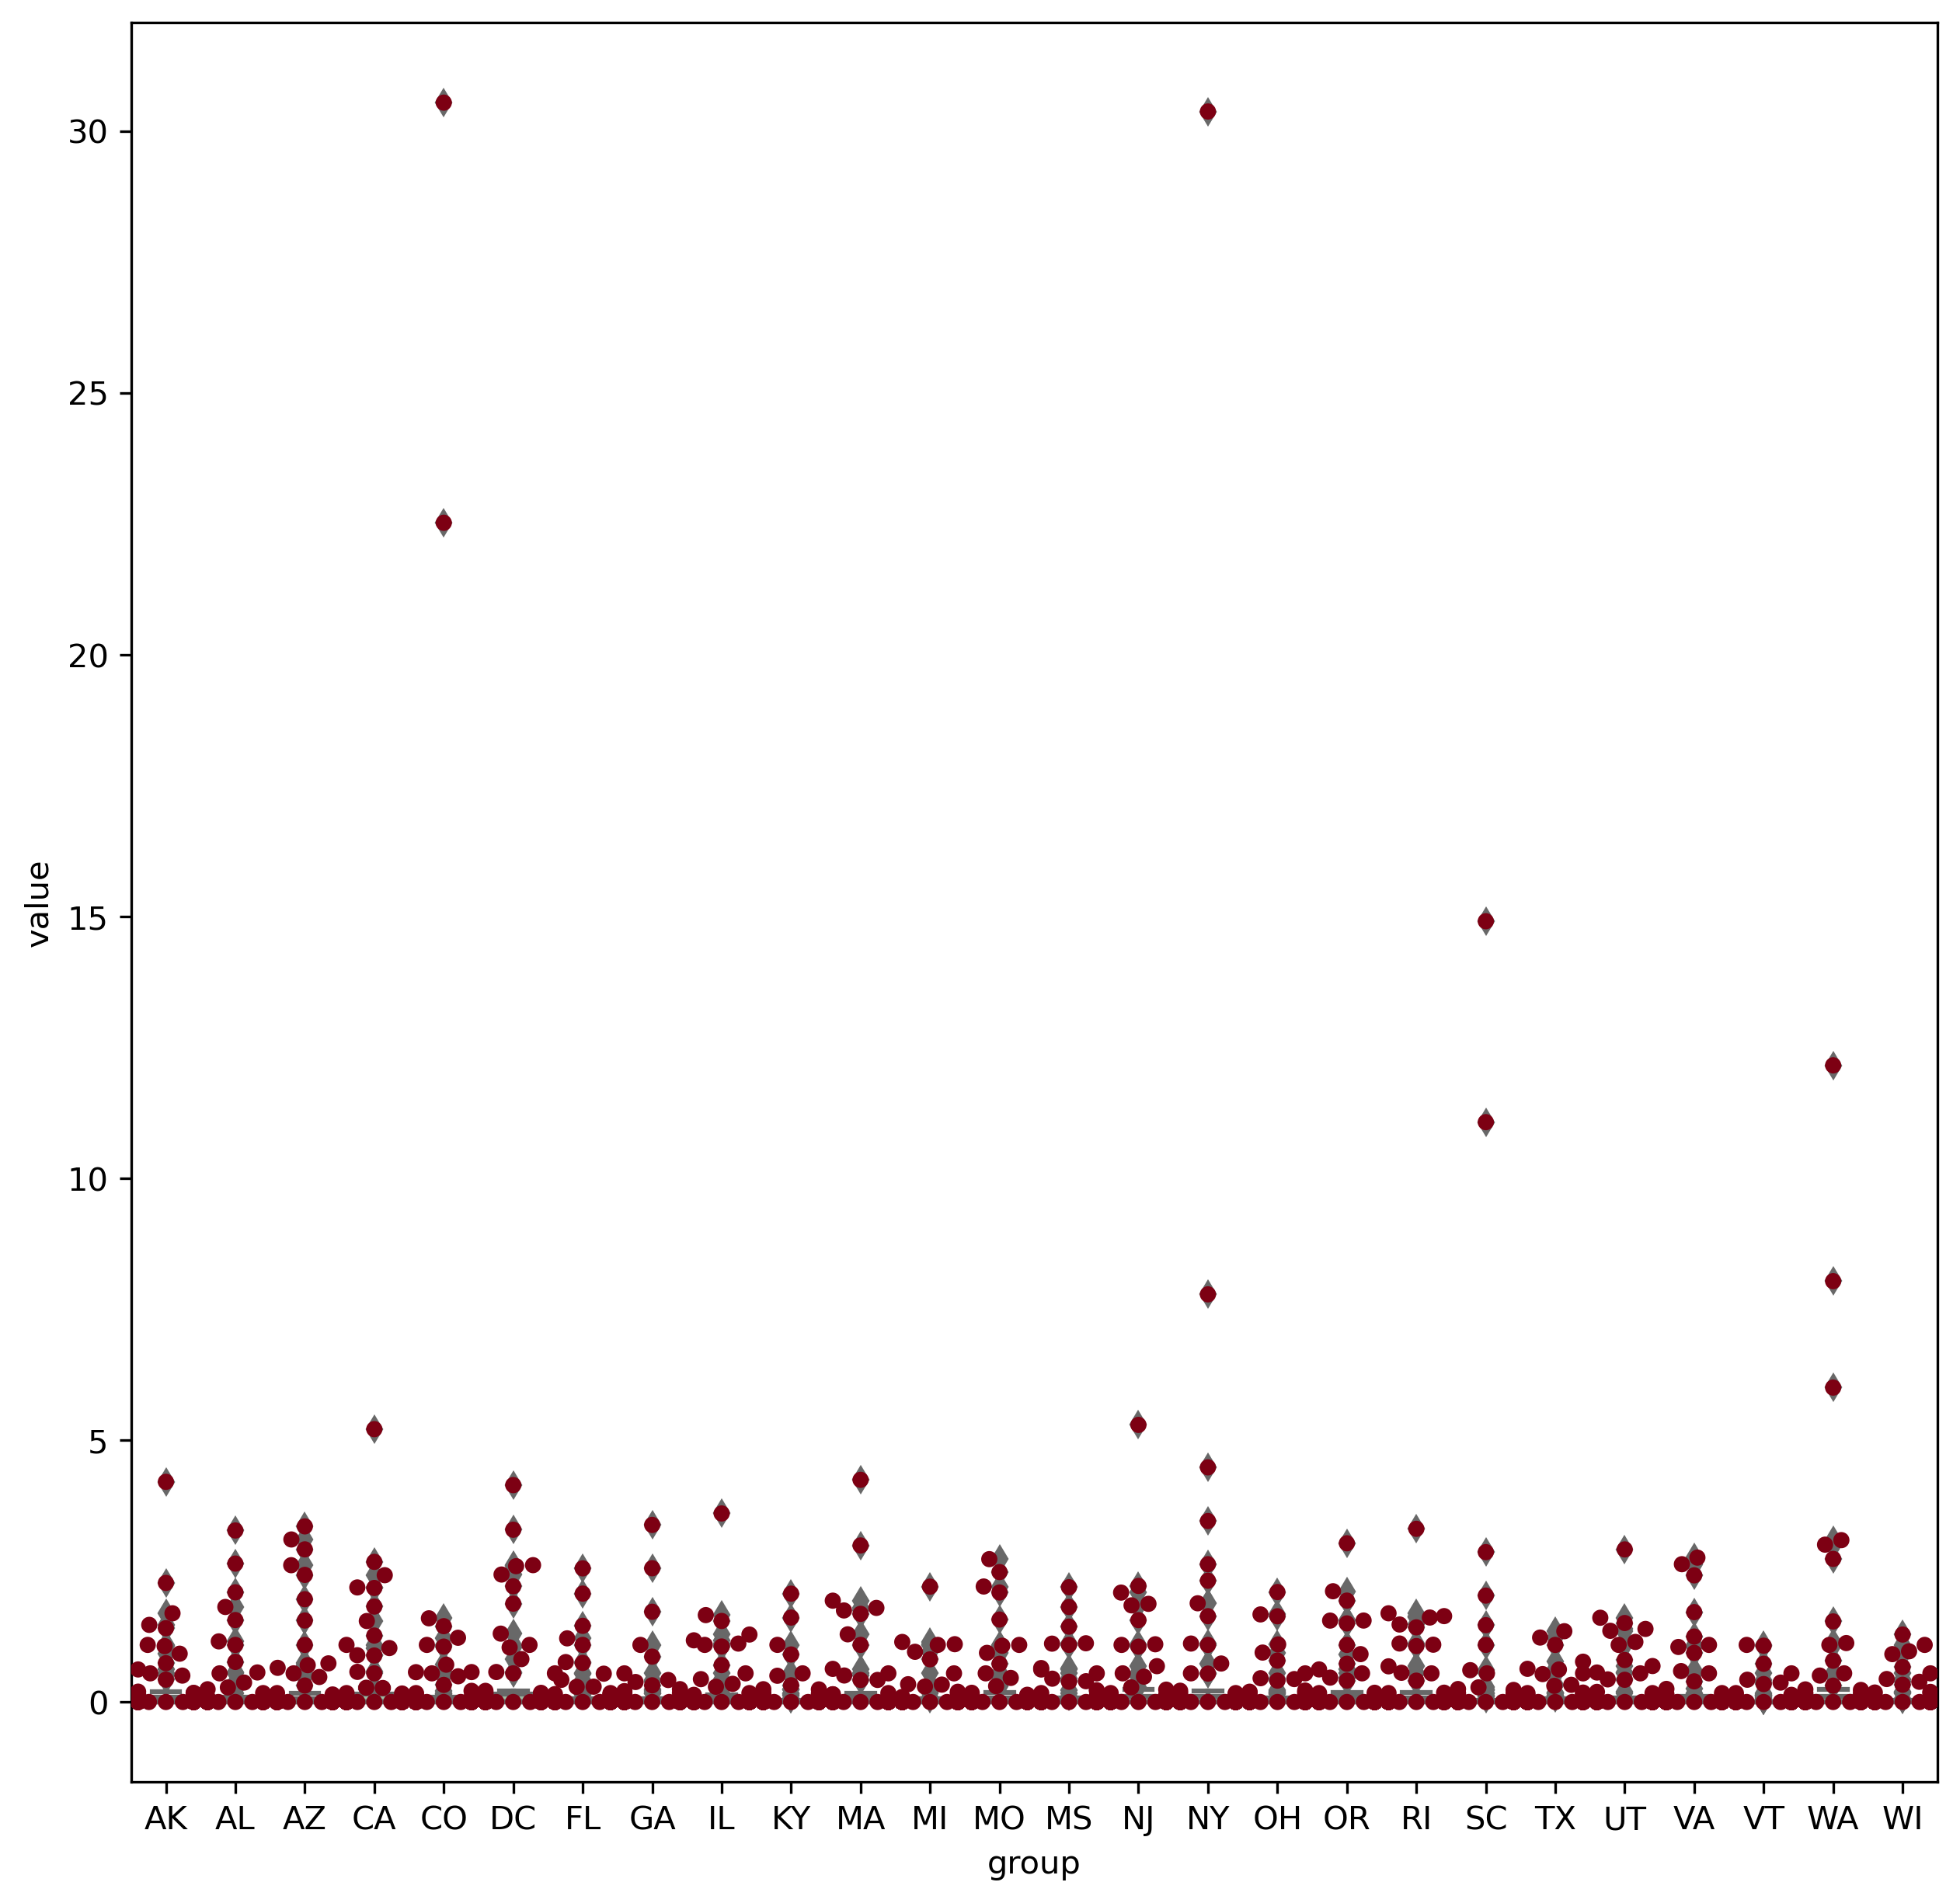

In [111]:
# generate a boxplot to see the data distribution
plt.figure(figsize=(10, 10))
ax = sns.boxplot(x='group', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="group", y="value", data=df_melt, color='#7d0013')
plt.show()

In [93]:
# ANOVA table using bioinfokit v1.0.3 or later 
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(group)')
res.anova_summary
# output (ANOVA F and p value)

df       sum_sq   mean_sq         F    PR(>F)
C(group)    25.0    77.010318  3.080413  1.580018  0.034195
Residual  1794.0  3497.593008  1.949606       NaN       NaN

In [94]:
#Set the max rows displayed in pandas to 10
pd.set_option('display.max_rows', None)


In [95]:
# perform multiple pairwise comparison (Tukey's HSD)
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='group', anova_model='value ~ C(group)')
res.tukey_summary

/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/bioinfokit/analys.py:365: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1 group2      Diff     Lower     Upper   q-value   p-value
0       AK     AL  0.014296 -0.855089  0.883682  0.085665  0.900000
1       AK     AZ  0.071379 -0.798006  0.940765  0.427709  0.900000
2       AK     CA  0.110522 -0.758863  0.979908  0.662255  0.900000
3       AK     CO  0.648556 -0.220830  1.517941  3.886180  0.514807
4       AK     DC  0.114642 -0.754743  0.984028  0.686944  0.900000
5       AK     FL  0.076689 -0.792697  0.946074  0.459524  0.900000
6       AK     GA  0.083647 -0.785738  0.953032  0.501217  0.900000
7       AK     IL  0.034706 -0.834679  0.904092  0.207961  0.900000
8       AK     KY  0.142188 -0.727198  1.011573  0.851997  0.900000
9       AK     MA  0.030112 -0.839274  0.899497  0.180430  0.900000
10      AK     MI  0.123055 -0.746331  0.992440  0.737350  0.900000
11      AK     MO  0.011447 -0.857939  0.880832  0.068589  0.900000
12      AK     MS  0.079483 -0.789903  0.948868  0.476264  0.900000
13      AK     NJ  0.045085 -0.824300  0.914471  0.270153  0.900000
14      AK     NY  0.595441 -0.273944  1.464826  3.567913  0.665603
15      AK     OH  0.098362 -0.771023  0.967748  0.589393  0.900000
16      AK     OR  0.008826 -0.860559  0.878211  0.052885  0.900000
17      AK     RI  0.007435 -0.861950  0.876821  0.044552  0.900000
18      AK     SC  0.255340 -0.614045  1.124726  1.530013  0.900000
19      AK     TX  0.140079 -0.729306  1.009465  0.839362  0.900000
20      AK     UT  0.042053 -0.827332  0.911438  0.251984  0.900000
21      AK     VA  0.023587 -0.845798  0.892973  0.141337  0.900000
22      AK     VT  0.183018 -0.686367  1.052403  1.096653  0.900000
23      AK     WA  0.345442 -0.523944  1.214827  2.069905  0.900000
24      AK     WI  0.153907 -0.715479  1.023292  0.922217  0.900000
25      AL     AZ  0.085676 -0.783710  0.955061  0.513373  0.900000
26      AL     CA  0.124819 -0.744567  0.994204  0.747919  0.900000
27      AL     CO  0.662852 -0.206533  1.532238  3.971845  0.473162
28      AL     DC  0.128939 -0.740447  0.998324  0.772608  0.900000
29      AL     FL  0.062392 -0.806993  0.931778  0.373859  0.900000
30      AL     GA  0.069351 -0.800035  0.938736  0.415552  0.900000
31      AL     IL  0.020410 -0.848976  0.889795  0.122297  0.900000
32      AL     KY  0.127891 -0.741494  0.997277  0.766332  0.900000
33      AL     MA  0.044408 -0.824977  0.913793  0.266095  0.900000
34      AL     MI  0.108758 -0.760627  0.978144  0.651686  0.900000
35      AL     MO  0.002850 -0.866536  0.872235  0.017076  0.900000
36      AL     MS  0.065186 -0.804199  0.934572  0.390599  0.900000
37      AL     NJ  0.059382 -0.810004  0.928767  0.355817  0.900000
38      AL     NY  0.609737 -0.259648  1.479123  3.653578  0.625016
39      AL     OH  0.084066 -0.785319  0.953451  0.503728  0.900000
40      AL     OR  0.005470 -0.863915  0.874856  0.032779  0.900000
41      AL     RI  0.006861 -0.862524  0.876247  0.041112  0.900000
42      AL     SC  0.269637 -0.599749  1.139022  1.615678  0.900000
43      AL     TX  0.125783 -0.743603  0.995168  0.753697  0.900000
44      AL     UT  0.027757 -0.841629  0.897142  0.166319  0.900000
45      AL     VA  0.009291 -0.860094  0.878676  0.055672  0.900000
46      AL     VT  0.168722 -0.700664  1.038107  1.010988  0.900000
47      AL     WA  0.359738 -0.509647  1.229123  2.155569  0.900000
48      AL     WI  0.139610 -0.729775  1.008996  0.836552  0.900000
49      AZ     CA  0.039143 -0.830243  0.908528  0.234546  0.900000
50      AZ     CO  0.577176 -0.292209  1.446562  3.458471  0.717455
51      AZ     DC  0.043263 -0.826122  0.912649  0.259235  0.900000
52      AZ     FL  0.148068 -0.721317  1.017454  0.887232  0.900000
53      AZ     GA  0.155026 -0.714359  1.024412  0.928925  0.900000
54      AZ     IL  0.106086 -0.763300  0.975471  0.635670  0.900000
55      AZ     KY  0.213567 -0.655818  1.082953  1.279706  0.900000
56      AZ     MA  0.041268 -0.828118  0.910653  0.247278  0.900000
57      AZ     MI  0.194434 -0.674951  1.063819  1.165059  0

In [96]:
#Set the max rows displayed in pandas to 10
pd.set_option('display.max_rows', 10)

# Binary Comparisons - Non-transormed

In [97]:
CA = ['CA', 'CA.1', 'CA.2']
TX = ['TX', 'TX.1','TX.2', 'TX.3', 'TX.4', 'TX.5', 'TX.6', 'TX.7', 'TX.8']

In [98]:
CA_df = df_b[CA]
TX_df = df_b[TX]

In [99]:
CATX = TwoCategoryMaster(df_b,TX_df,CA_df,"TX","CA")
CATX.head(10)

AK        AL        AZ        CA  \
Chemical                                                                       
1_1_1-Trichloroethane (¬µg/m3)        0.071949  0.063815  0.080853  0.077393   
1_1_2-Trichloroethane (¬µg/m3)        0.000386  0.000413  0.000386  0.000397   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000840  0.000199  0.000018  0.000123   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  0.000001  0.000001   
1_3-Butadiene (¬µg/m3)                0.197509  0.065719  0.075517  0.110161   
1_3-Dichloropropene (¬µg/m3)          0.000623  0.000084  0.000163  0.032852   
1_4-Dichlorobenzene (¬µg/m3)          0.009270  0.000302  0.000836  0.272366   
2_2_4-Trimethylpentane (¬µg/m3)       1.067067  0.371113  0.703446  0.892935   
Acetaldehyde (¬µg/m3)                 0.426471  3.274960  3.103408  2.177506   
Acetonitrile (¬µg/m3)                 0.170003  0.170001  0.170002  0.170012   

                                          CA.1      CA.2        CO        DC  \
Chemical                                                                       
1_1_1-Trichloroethane (¬µg/m3)        0.064345  4.506996  0.060000  0.160085   
1_1_2-Trichloroethane (¬µg/m3)        0.000387  0.000386  0.000387  0.000387   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000089  0.000178  0.000227  0.000063   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  0.000001  0.000001   
1_3-Butadiene (¬µg/m3)                0.053473  0.102434  0.056482  0.147935   
1_3-Dichloropropene (¬µg/m3)          0.017076  0.015403  0.000068  0.075156   
1_4-Dichlorobenzene (¬µg/m3)          0.144954  0.170401  0.000722  0.027725   
2_2_4-Trimethylpentane (¬µg/m3)       0.428733  0.887912  0.326326  0.818662   
Acetaldehyde (¬µg/m3)                 1.894765  1.704062  1.598139  2.593681   
Acetonitrile (¬µg/m3)                 0.170000  0.170874  0.170000  0.170130   

                                            FL      FL.1  ...      WA.3  \
Chemical                                                  ...             
1_1_1-Trichloroethane (¬µg/m3)        0.062125  0.071878  ...  0.068299   
1_1_2-Trichloroethane (¬µg/m3)        0.000386  0.000386  ...  0.000386   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000076  0.001527  ...  0.000159   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  ...  0.000001   
1_3-Butadiene (¬µg/m3)                0.039993  0.070932  ...  0.118631   
1_3-Dichloropropene (¬µg/m3)          0.001161  0.000058  ...  0.000055   
1_4-Dichlorobenzene (¬µg/m3)          0.000098  0.000368  ...  0.000120   
2_2_4-Trimethylpentane (¬µg/m3)       0.288708  0.655704  ...  0.585186   
Acetaldehyde (¬µg/m3)                 2.551728  2.013978  ...  1.532978   
Acetonitrile (¬µg/m3)                 0.170001  0.170000  ...  0.170546   

                                            WI      WI.1  ttest_pvalue  \
Chemical                                                                 
1_1_1-Trichloroethane (¬µg/m3)        0.060915  0.061260      0.420922   
1_1_2-Trichloroethane (¬µg/m3)        0.000386  0.000386      0.354498   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000003  0.000052      0.097465   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001      0.022204   
1_3-Butadiene (¬µg/m3)                0.023961  0.017629      0.056675   
1_3-Dichloropropene (¬µg/m3)          0.000081  0.001392      0.059550   
1_4-Dichlorobenzene (¬µg/m3)          0.000351  0.000279      0.037455   
2_2_4-Trimethylpentane (¬µg/m3)       0.180696  0.155215      0.096866   
Acetaldehyde (¬µg/m3)                 1.287895  1.263175      0.931451   
Acetonitrile (¬µg/m3)                 0.170001  0.170001      0.409237   

                                       TX Mean   CA Mean  Fold Change(TX/CA)  \
Chemical                                                                       
1_1_1-Trichloroethane (¬µg/m3)        0.064211  1.549578            0.041438   
1_1_2-Trichloroethane (¬µg/m3)        0.000415  0.000390            1.063689   
1_1_2_2-Tetr

In [100]:
CATXr = CATX.reset_index()
CATXr.head(10)

Chemical        AK        AL        AZ  \
0        1_1_1-Trichloroethane (¬µg/m3)  0.071949  0.063815  0.080853   
1        1_1_2-Trichloroethane (¬µg/m3)  0.000386  0.000413  0.000386   
2    1_1_2_2-Tetrachloroethane (¬µg/m3)  0.000840  0.000199  0.000018   
3  1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  0.000001   
4                1_3-Butadiene (¬µg/m3)  0.197509  0.065719  0.075517   
5          1_3-Dichloropropene (¬µg/m3)  0.000623  0.000084  0.000163   
6          1_4-Dichlorobenzene (¬µg/m3)  0.009270  0.000302  0.000836   
7       2_2_4-Trimethylpentane (¬µg/m3)  1.067067  0.371113  0.703446   
8                 Acetaldehyde (¬µg/m3)  0.426471  3.274960  3.103408   
9                 Acetonitrile (¬µg/m3)  0.170003  0.170001  0.170002   

         CA      CA.1      CA.2        CO        DC        FL  ...      WA.3  \
0  0.077393  0.064345  4.506996  0.060000  0.160085  0.062125  ...  0.068299   
1  0.000397  0.000387  0.000386  0.000387  0.000387  0.000386  ...  0.000386   
2  0.000123  0.000089  0.000178  0.000227  0.000063  0.000076  ...  0.000159   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  ...  0.000001   
4  0.110161  0.053473  0.102434  0.056482  0.147935  0.039993  ...  0.118631   
5  0.032852  0.017076  0.015403  0.000068  0.075156  0.001161  ...  0.000055   
6  0.272366  0.144954  0.170401  0.000722  0.027725  0.000098  ...  0.000120   
7  0.892935  0.428733  0.887912  0.326326  0.818662  0.288708  ...  0.585186   
8  2.177506  1.894765  1.704062  1.598139  2.593681  2.551728  ...  1.532978   
9  0.170012  0.170000  0.170874  0.170000  0.170130  0.170001  ...  0.170546   

         WI      WI.1  ttest_pvalue   TX Mean   CA Mean  Fold Change(TX/CA)  \
0  0.060915  0.061260      0.420922  0.064211  1.549578            0.041438   
1  0.000386  0.000386      0.354498  0.000415  0.000390            1.063689   
2  0.000003  0.000052      0.097465  0.000050  0.000130            0.383337   
3  0.000001  0.000001      0.022204  0.000001  0.000001            1.000000   
4  0.023961  0.017629      0.056675  0.032099  0.088689            0.361931   
5  0.000081  0.001392      0.059550  0.000029  0.021777            0.001313   
6  0.000351  0.000279      0.037455  0.000476  0.195907            0.002428   
7  0.180696  0.155215      0.096866  0.293391  0.736527            0.398344   
8  1.287895  1.263175      0.931451  1.902531  1.925444            0.988100   
9  0.170001  0.170001      0.409237  0.172373  0.170295            1.012202   

   Log2(Fold Change)  -Log(P-value)  TX/CA pi score  
0      -4.592917e+00       0.375798   -1.726011e+00  
1       8.907598e-02       0.450386    4.011860e-02  
2      -1.383315e+00       1.011153   -1.398743e+00  
3      -1.601713e-16       1.653571   -2.648546e-16  
4      -1.466215e+00       1.246612   -1.827801e+00  
5      -9.572928e+00       1.225118   -1.172796e+01  
6      -8.686297e+00       1.426488   -1.239090e+01  
7      -1.327915e+00       1.013827   -1.346276e+00  
8      -1.727120e-02       0.030840   -5.326443e-04  
9       1.749704e-02       0.388025    6.789285e-03  

[10 rows x 79 columns]

In [101]:
CATXd = CATXr.dropna()
CATXd.head(10)

Chemical        AK        AL        AZ  \
0        1_1_1-Trichloroethane (¬µg/m3)  0.071949  0.063815  0.080853   
1        1_1_2-Trichloroethane (¬µg/m3)  0.000386  0.000413  0.000386   
2    1_1_2_2-Tetrachloroethane (¬µg/m3)  0.000840  0.000199  0.000018   
3  1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  0.000001   
4                1_3-Butadiene (¬µg/m3)  0.197509  0.065719  0.075517   
5          1_3-Dichloropropene (¬µg/m3)  0.000623  0.000084  0.000163   
6          1_4-Dichlorobenzene (¬µg/m3)  0.009270  0.000302  0.000836   
7       2_2_4-Trimethylpentane (¬µg/m3)  1.067067  0.371113  0.703446   
8                 Acetaldehyde (¬µg/m3)  0.426471  3.274960  3.103408   
9                 Acetonitrile (¬µg/m3)  0.170003  0.170001  0.170002   

         CA      CA.1      CA.2        CO        DC        FL  ...      WA.3  \
0  0.077393  0.064345  4.506996  0.060000  0.160085  0.062125  ...  0.068299   
1  0.000397  0.000387  0.000386  0.000387  0.000387  0.000386  ...  0.000386   
2  0.000123  0.000089  0.000178  0.000227  0.000063  0.000076  ...  0.000159   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  ...  0.000001   
4  0.110161  0.053473  0.102434  0.056482  0.147935  0.039993  ...  0.118631   
5  0.032852  0.017076  0.015403  0.000068  0.075156  0.001161  ...  0.000055   
6  0.272366  0.144954  0.170401  0.000722  0.027725  0.000098  ...  0.000120   
7  0.892935  0.428733  0.887912  0.326326  0.818662  0.288708  ...  0.585186   
8  2.177506  1.894765  1.704062  1.598139  2.593681  2.551728  ...  1.532978   
9  0.170012  0.170000  0.170874  0.170000  0.170130  0.170001  ...  0.170546   

         WI      WI.1  ttest_pvalue   TX Mean   CA Mean  Fold Change(TX/CA)  \
0  0.060915  0.061260      0.420922  0.064211  1.549578            0.041438   
1  0.000386  0.000386      0.354498  0.000415  0.000390            1.063689   
2  0.000003  0.000052      0.097465  0.000050  0.000130            0.383337   
3  0.000001  0.000001      0.022204  0.000001  0.000001            1.000000   
4  0.023961  0.017629      0.056675  0.032099  0.088689            0.361931   
5  0.000081  0.001392      0.059550  0.000029  0.021777            0.001313   
6  0.000351  0.000279      0.037455  0.000476  0.195907            0.002428   
7  0.180696  0.155215      0.096866  0.293391  0.736527            0.398344   
8  1.287895  1.263175      0.931451  1.902531  1.925444            0.988100   
9  0.170001  0.170001      0.409237  0.172373  0.170295            1.012202   

   Log2(Fold Change)  -Log(P-value)  TX/CA pi score  
0      -4.592917e+00       0.375798   -1.726011e+00  
1       8.907598e-02       0.450386    4.011860e-02  
2      -1.383315e+00       1.011153   -1.398743e+00  
3      -1.601713e-16       1.653571   -2.648546e-16  
4      -1.466215e+00       1.246612   -1.827801e+00  
5      -9.572928e+00       1.225118   -1.172796e+01  
6      -8.686297e+00       1.426488   -1.239090e+01  
7      -1.327915e+00       1.013827   -1.346276e+00  
8      -1.727120e-02       0.030840   -5.326443e-04  
9       1.749704e-02       0.388025    6.789285e-03  

[10 rows x 79 columns]

# Binary comparison - CA vs GA

In [113]:
GA = ['GA', 'GA.1','GA.2', 'GA.3', 'GA.4', 'GA.5', 'GA.6', 'GA.7', 'GA.8', 'GA.9', 'GA.10', 'GA.11', 'GA.12', 'GA.13']
GA_df = df_b[GA]

In [114]:
CAGA = TwoCategoryMaster(df_b,GA_df,CA_df,"GA","CA")
CAGA.head(10)

AK        AL        AZ        CA  \
Chemical                                                                       
1_1_1-Trichloroethane (¬µg/m3)        0.071949  0.063815  0.080853  0.077393   
1_1_2-Trichloroethane (¬µg/m3)        0.000386  0.000413  0.000386  0.000397   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000840  0.000199  0.000018  0.000123   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  0.000001  0.000001   
1_3-Butadiene (¬µg/m3)                0.197509  0.065719  0.075517  0.110161   
1_3-Dichloropropene (¬µg/m3)          0.000623  0.000084  0.000163  0.032852   
1_4-Dichlorobenzene (¬µg/m3)          0.009270  0.000302  0.000836  0.272366   
2_2_4-Trimethylpentane (¬µg/m3)       1.067067  0.371113  0.703446  0.892935   
Acetaldehyde (¬µg/m3)                 0.426471  3.274960  3.103408  2.177506   
Acetonitrile (¬µg/m3)                 0.170003  0.170001  0.170002  0.170012   

                                          CA.1      CA.2        CO        DC  \
Chemical                                                                       
1_1_1-Trichloroethane (¬µg/m3)        0.064345  4.506996  0.060000  0.160085   
1_1_2-Trichloroethane (¬µg/m3)        0.000387  0.000386  0.000387  0.000387   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000089  0.000178  0.000227  0.000063   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  0.000001  0.000001   
1_3-Butadiene (¬µg/m3)                0.053473  0.102434  0.056482  0.147935   
1_3-Dichloropropene (¬µg/m3)          0.017076  0.015403  0.000068  0.075156   
1_4-Dichlorobenzene (¬µg/m3)          0.144954  0.170401  0.000722  0.027725   
2_2_4-Trimethylpentane (¬µg/m3)       0.428733  0.887912  0.326326  0.818662   
Acetaldehyde (¬µg/m3)                 1.894765  1.704062  1.598139  2.593681   
Acetonitrile (¬µg/m3)                 0.170000  0.170874  0.170000  0.170130   

                                            FL      FL.1  ...  ttest_pvalue  \
Chemical                                                  ...                 
1_1_1-Trichloroethane (¬µg/m3)        0.062125  0.071878  ...      0.421427   
1_1_2-Trichloroethane (¬µg/m3)        0.000386  0.000386  ...      0.444588   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000076  0.001527  ...      0.211591   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  ...      0.335561   
1_3-Butadiene (¬µg/m3)                0.039993  0.070932  ...      0.156285   
1_3-Dichloropropene (¬µg/m3)          0.001161  0.000058  ...      0.059982   
1_4-Dichlorobenzene (¬µg/m3)          0.000098  0.000368  ...      0.037442   
2_2_4-Trimethylpentane (¬µg/m3)       0.288708  0.655704  ...      0.106071   
Acetaldehyde (¬µg/m3)                 2.551728  2.013978  ...      0.001756   
Acetonitrile (¬µg/m3)                 0.170001  0.170000  ...      0.441250   

                                       TX Mean   CA Mean  Fold Change(TX/CA)  \
Chemical                                                                       
1_1_1-Trichloroethane (¬µg/m3)        0.064211  1.549578            0.041438   
1_1_2-Trichloroethane (¬µg/m3)        0.000415  0.000390            1.063689   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000050  0.000130            0.383337   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001            1.000000   
1_3-Butadiene (¬µg/m3)                0.032099  0.088689            0.361931   
1_3-Dichloropropene (¬µg/m3)          0.000029  0.021777            0.001313   
1_4-Dichlorobenzene (¬µg/m3)          0.000476  0.195907            0.002428   
2_2_4-Trimethylpentane (¬µg/m3)       0.293391  0.736527            0.398344   
Acetaldehyde (¬µg/m3)                 1.902531  1.925444            0.988100   
Acetonitrile (¬µg/m3)                 0.172373  0.170295            1.012202   

                                      Log2(Fold Change)  -Log(P-value)  \
Chemical                                                                 
1_1_1-Trichloroethane (¬µg/m3)                -4.549821       0.

In [115]:
CAGAr = CAGA.reset_index()
CAGAr.head(5)

Chemical        AK        AL        AZ  \
0        1_1_1-Trichloroethane (¬µg/m3)  0.071949  0.063815  0.080853   
1        1_1_2-Trichloroethane (¬µg/m3)  0.000386  0.000413  0.000386   
2    1_1_2_2-Tetrachloroethane (¬µg/m3)  0.000840  0.000199  0.000018   
3  1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  0.000001   
4                1_3-Butadiene (¬µg/m3)  0.197509  0.065719  0.075517   

         CA      CA.1      CA.2        CO        DC        FL  ...  \
0  0.077393  0.064345  4.506996  0.060000  0.160085  0.062125  ...   
1  0.000397  0.000387  0.000386  0.000387  0.000387  0.000386  ...   
2  0.000123  0.000089  0.000178  0.000227  0.000063  0.000076  ...   
3  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  ...   
4  0.110161  0.053473  0.102434  0.056482  0.147935  0.039993  ...   

   ttest_pvalue   TX Mean   CA Mean  Fold Change(TX/CA)  Log2(Fold Change)  \
0      0.421427  0.064211  1.549578            0.041438          -4.549821   
1      0.444588  0.000415  0.000390            1.063689           0.015898   
2      0.211591  0.000050  0.000130            0.383337           0.943284   
3      0.335561  0.000001  0.000001            1.000000           0.535158   
4      0.156285  0.032099  0.088689            0.361931          -0.776522   

   -Log(P-value)  TX/CA pi score   GA Mean  Fold Change(GA/CA)  GA/CA pi score  
0       0.375278   -1.726011e+00  0.066158            0.042694       -1.707447  
1       0.352042    4.011860e-02  0.000394            1.011080        0.005597  
2       0.674502   -1.398743e+00  0.000250            1.922901        0.636247  
3       0.474228   -2.648546e-16  0.000002            1.449101        0.253787  
4       0.806082   -1.827801e+00  0.051774            0.583772       -0.625940  

[5 rows x 82 columns]

In [116]:
CAGAd = CAGAr.dropna()
CAGAd.describe()

AK         AL            AZ            CA          CA.1  \
count  6.900000e+01  69.000000  6.900000e+01  6.900000e+01  6.900000e+01   
mean   2.647367e-01   0.250233  3.371506e-01  3.768607e-01  2.356719e-01   
std    6.645333e-01   0.636877  8.031669e-01  8.739455e-01  5.349688e-01   
min    5.700000e-08   0.000001  1.940000e-07  1.000000e-10  4.950000e-08   
25%    2.857767e-04   0.000302  1.112266e-04  3.230410e-04  1.449702e-04   
50%    5.497109e-03   0.005520  1.662039e-03  5.750748e-03  5.466996e-03   
75%    9.203642e-02   0.058785  7.551735e-02  1.618392e-01  6.883975e-02   
max    4.203952e+00   3.274960  3.353296e+00  5.209938e+00  2.660852e+00   

               CA.2            CO         DC         FL       FL.1  ...  \
count  6.900000e+01  6.900000e+01  69.000000  69.000000  69.000000  ...   
mean   3.881030e-01  9.226918e-01   0.381041   0.186936   0.238071  ...   
std    9.040416e-01  4.523428e+00   0.868967   0.474994   0.542659  ...   
min    2.190000e-08  2.160000e-08   0.000001   0.000001   0.000001  ...   
25%    2.772646e-04  9.254010e-05   0.000280   0.000181   0.000235  ...   
50%    5.498626e-03  5.626733e-04   0.006131   0.001082   0.002663  ...   
75%    1.708740e-01  6.000000e-02   0.147935   0.045870   0.071878  ...   
max    4.506996e+00  3.054037e+01   4.141487   2.551728   2.739066  ...   

       ttest_pvalue    TX Mean    CA Mean  Fold Change(TX/CA)  \
count     69.000000  69.000000  69.000000           69.000000   
mean       0.270911   0.185691   0.333545            6.613813   
std        0.234287   0.414968   0.722421           27.111600   
min        0.000087   0.000001   0.000001            0.001313   
25%        0.076334   0.000189   0.000390            0.219875   
50%        0.211591   0.005752   0.005599            0.593352   
75%        0.441250   0.068286   0.195907            1.063689   
max        0.932643   1.902531   4.078037          204.072872   

       Log2(Fold Change)  -Log(P-value)  TX/CA pi score    GA Mean  \
count          69.000000      69.000000       69.000000  69.000000   
mean           -0.938503       0.843927       -1.555138   0.221885   
std             2.273646       0.695252        3.657566   0.569693   
min            -8.872989       0.030285      -19.179156   0.000002   
25%            -1.588271       0.355315       -2.178966   0.000250   
50%            -0.776522       0.674502       -0.374077   0.002380   
75%             0.225799       1.117282        0.023097   0.066158   
max             4.131698       4.061443        3.551831   3.092563   

       Fold Change(GA/CA)  GA/CA pi score  
count           69.000000       69.000000  
mean             1.312131       -0.919239  
std              2.403026        2.733550  
min              0.002133      -12.658615  
25%              0.332570       -1.492394  
50%              0.583772       -0.390461  
75%              1.169424        0.070108  
max             17.529314        7.613471  

[8 rows x 81 columns]

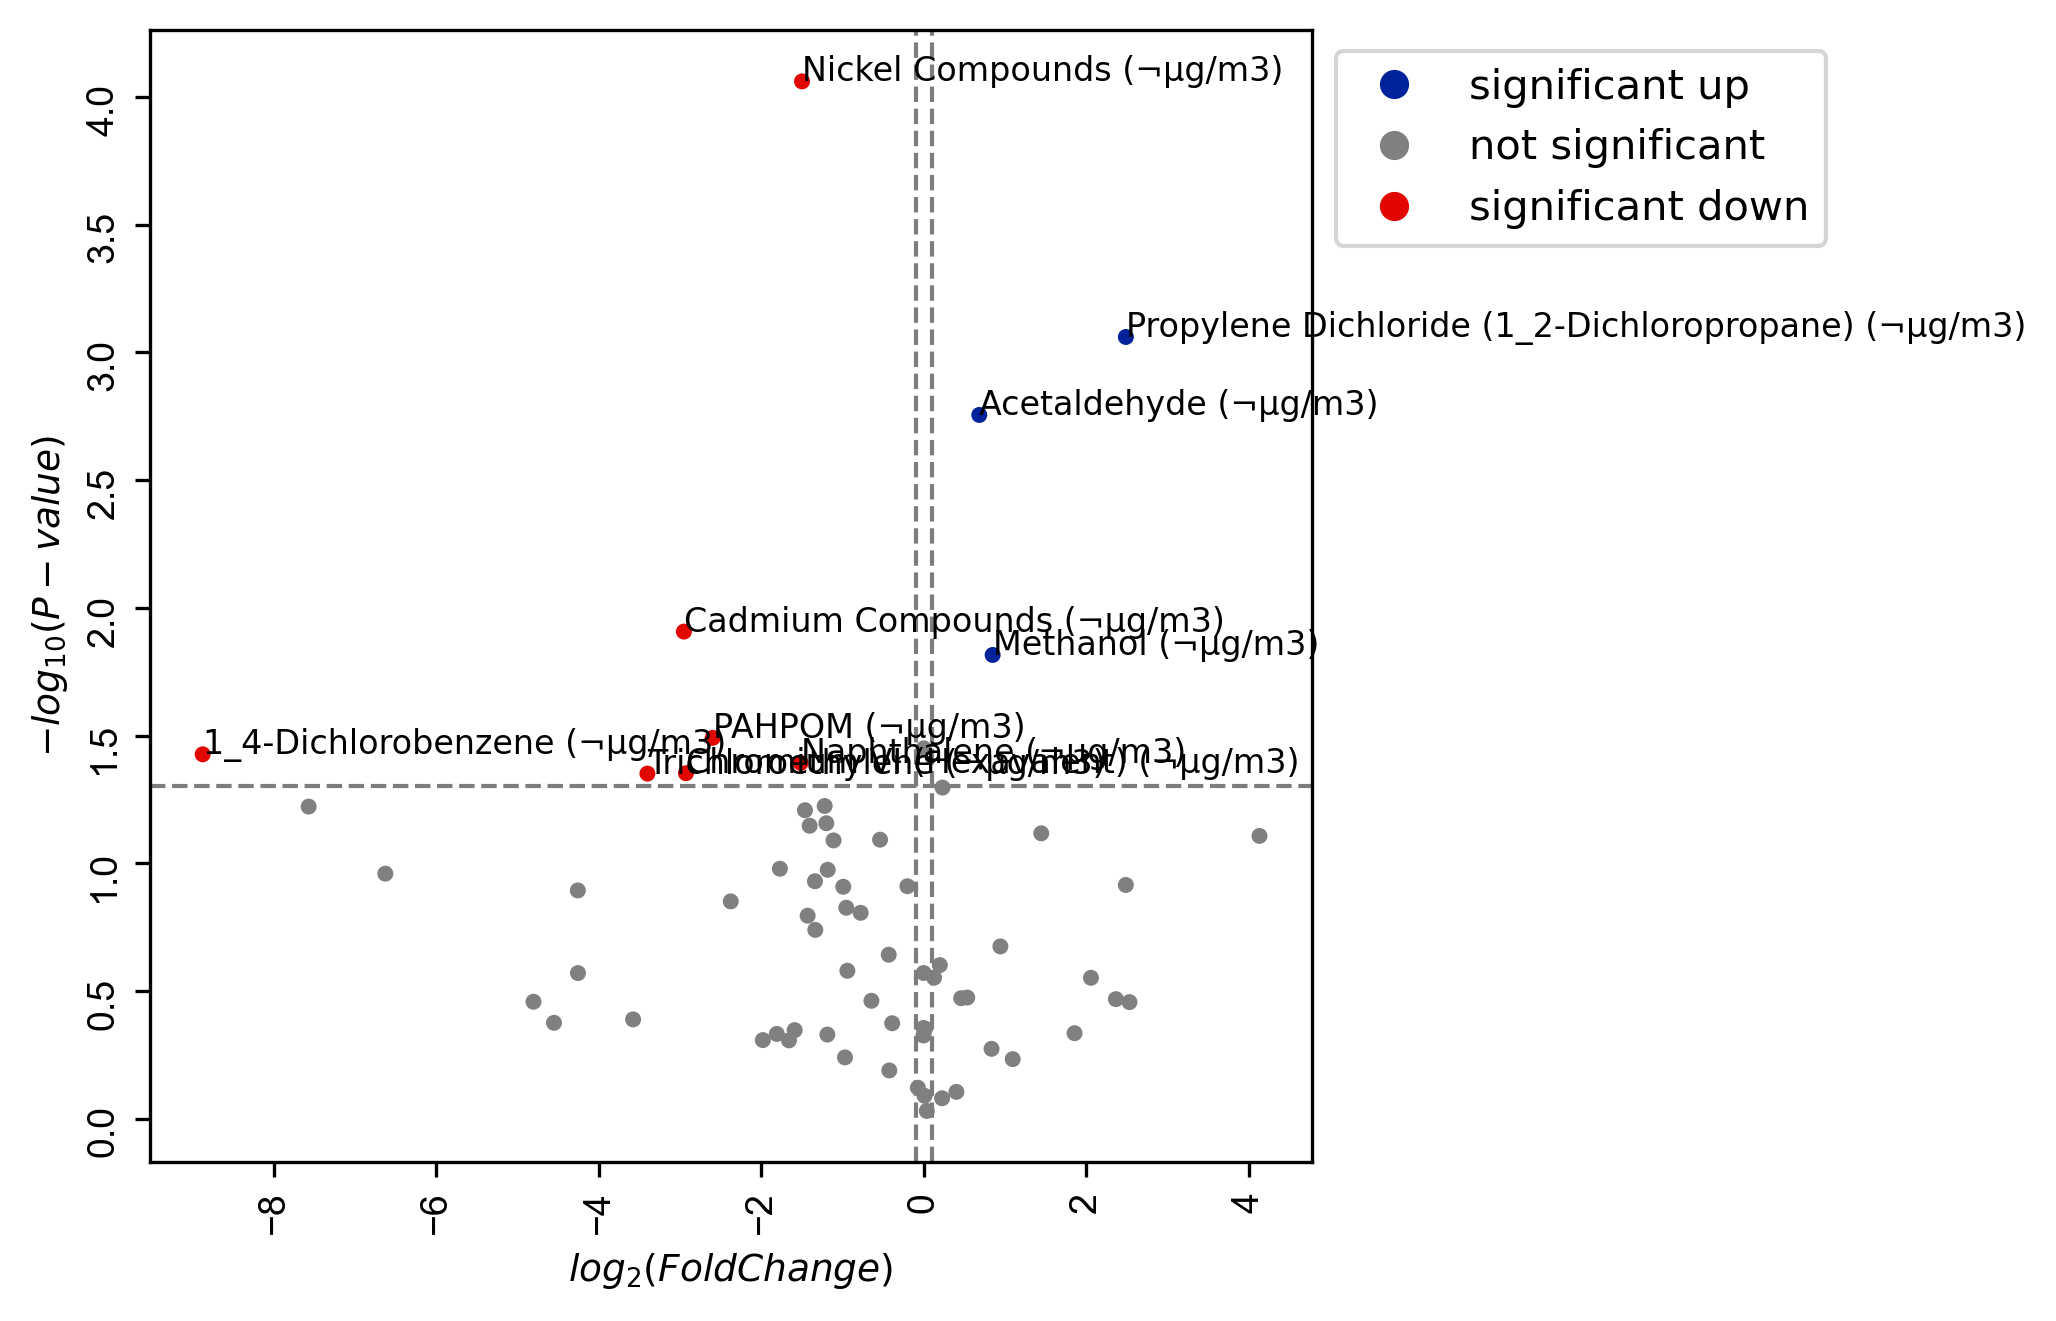

In [117]:
#Visualize binary comparison 
visuz.gene_exp.volcano(df=CAGAd, show = True, lfc='Log2(Fold Change)', pv='ttest_pvalue', geneid="Chemical", lfc_thr=(.1, .1), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1), r=1200)

In [118]:
#Because we need to log2tranform the data, replace any values with 0 wth NaN and then remove them

dfr = df_b.replace(0, np.nan)
dfd = dfr.dropna()
dfd

AK        AL        AZ        CA  \
Chemical                                                                       
1_1_1-Trichloroethane (¬µg/m3)        0.071949  0.063815  0.080853  0.077393   
1_1_2-Trichloroethane (¬µg/m3)        0.000386  0.000413  0.000386  0.000397   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000840  0.000199  0.000018  0.000123   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  0.000001  0.000001   
1_3-Butadiene (¬µg/m3)                0.197509  0.065719  0.075517  0.110161   
...                                        ...       ...       ...       ...   
Trichloroethylene (¬µg/m3)            0.009107  0.031461  0.001794  0.091247   
Triethylamine (¬µg/m3)                0.001888  0.001022  0.002885  0.002611   
Vinyl Acetate (¬µg/m3)                0.000064  0.000046  0.000115  0.000584   
Vinyl Chloride (¬µg/m3)               0.000116  0.000492  0.000038  0.000323   
Xylenes (Mixed Isomers) (¬µg/m3)      2.273865  1.157399  1.555841  2.675677   

                                          CA.1      CA.2        CO        DC  \
Chemical                                                                       
1_1_1-Trichloroethane (¬µg/m3)        0.064345  4.506996  0.060000  0.160085   
1_1_2-Trichloroethane (¬µg/m3)        0.000387  0.000386  0.000387  0.000387   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000089  0.000178  0.000227  0.000063   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  0.000001  0.000001   
1_3-Butadiene (¬µg/m3)                0.053473  0.102434  0.056482  0.147935   
...                                        ...       ...       ...       ...   
Trichloroethylene (¬µg/m3)            0.043902  0.084937  0.000413  0.007729   
Triethylamine (¬µg/m3)                0.001325  0.001901  0.000436  0.002597   
Vinyl Acetate (¬µg/m3)                0.000136  0.004423  0.000035  0.000183   
Vinyl Chloride (¬µg/m3)               0.000292  0.002786  0.000543  0.000354   
Xylenes (Mixed Isomers) (¬µg/m3)      1.408800  2.238695  0.712528  2.209622   

                                            FL      FL.1  ...  ttest_pvalue  \
Chemical                                                  ...                 
1_1_1-Trichloroethane (¬µg/m3)        0.062125  0.071878  ...      0.421427   
1_1_2-Trichloroethane (¬µg/m3)        0.000386  0.000386  ...      0.444588   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000076  0.001527  ...      0.211591   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001  ...      0.335561   
1_3-Butadiene (¬µg/m3)                0.039993  0.070932  ...      0.156285   
...                                        ...       ...  ...           ...   
Trichloroethylene (¬µg/m3)            0.000532  0.004724  ...      0.044550   
Triethylamine (¬µg/m3)                0.000620  0.002122  ...      0.061996   
Vinyl Acetate (¬µg/m3)                0.000041  0.000064  ...      0.348375   
Vinyl Chloride (¬µg/m3)               0.000205  0.005374  ...      0.575578   
Xylenes (Mixed Isomers) (¬µg/m3)      0.762140  1.372637  ...      0.059646   

                                       TX Mean   CA Mean  Fold Change(TX/CA)  \
Chemical                                                                       
1_1_1-Trichloroethane (¬µg/m3)        0.064211  1.549578            0.041438   
1_1_2-Trichloroethane (¬µg/m3)        0.000415  0.000390            1.063689   
1_1_2_2-Tetrachloroethane (¬µg/m3)    0.000050  0.000130            0.383337   
1_2-Dibromo-3-Chloropropane (¬µg/m3)  0.000001  0.000001            1.000000   
1_3-Butadiene (¬µg/m3)                0.032099  0.088689            0.361931   
...                                        ...       ...                 ...   
Trichloroethylene (¬µg/m3)            0.002355  0.073362            0.032105   
Triethylamine (¬µg/m3)                0.000467  0.001946            0.240129   
Vinyl Acetate (¬µg/m3)                0.011303  0.001714            6.594002   
Vinyl Chloride (¬µg/m3)               0.001171  0.0011

array([[<AxesSubplot:title={'center':'AK'}>,
        <AxesSubplot:title={'center':'AL'}>,
        <AxesSubplot:title={'center':'AZ'}>,
        <AxesSubplot:title={'center':'CA'}>,
        <AxesSubplot:title={'center':'CA.1'}>,
        <AxesSubplot:title={'center':'CA.2'}>,
        <AxesSubplot:title={'center':'CO'}>,
        <AxesSubplot:title={'center':'DC'}>,
        <AxesSubplot:title={'center':'FL'}>],
       [<AxesSubplot:title={'center':'FL.1'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA.1'}>,
        <AxesSubplot:title={'center':'GA.2'}>,
        <AxesSubplot:title={'center':'GA.3'}>,
        <AxesSubplot:title={'center':'GA.4'}>,
        <AxesSubplot:title={'center':'GA.5'}>,
        <AxesSubplot:title={'center':'GA.6'}>,
        <AxesSubplot:title={'center':'GA.7'}>],
       [<AxesSubplot:title={'center':'GA.8'}>,
        <AxesSubplot:title={'center':'GA.9'}>,
        <AxesSubplot:title={'center':'GA.10'}>,
        <AxesSubplot:title

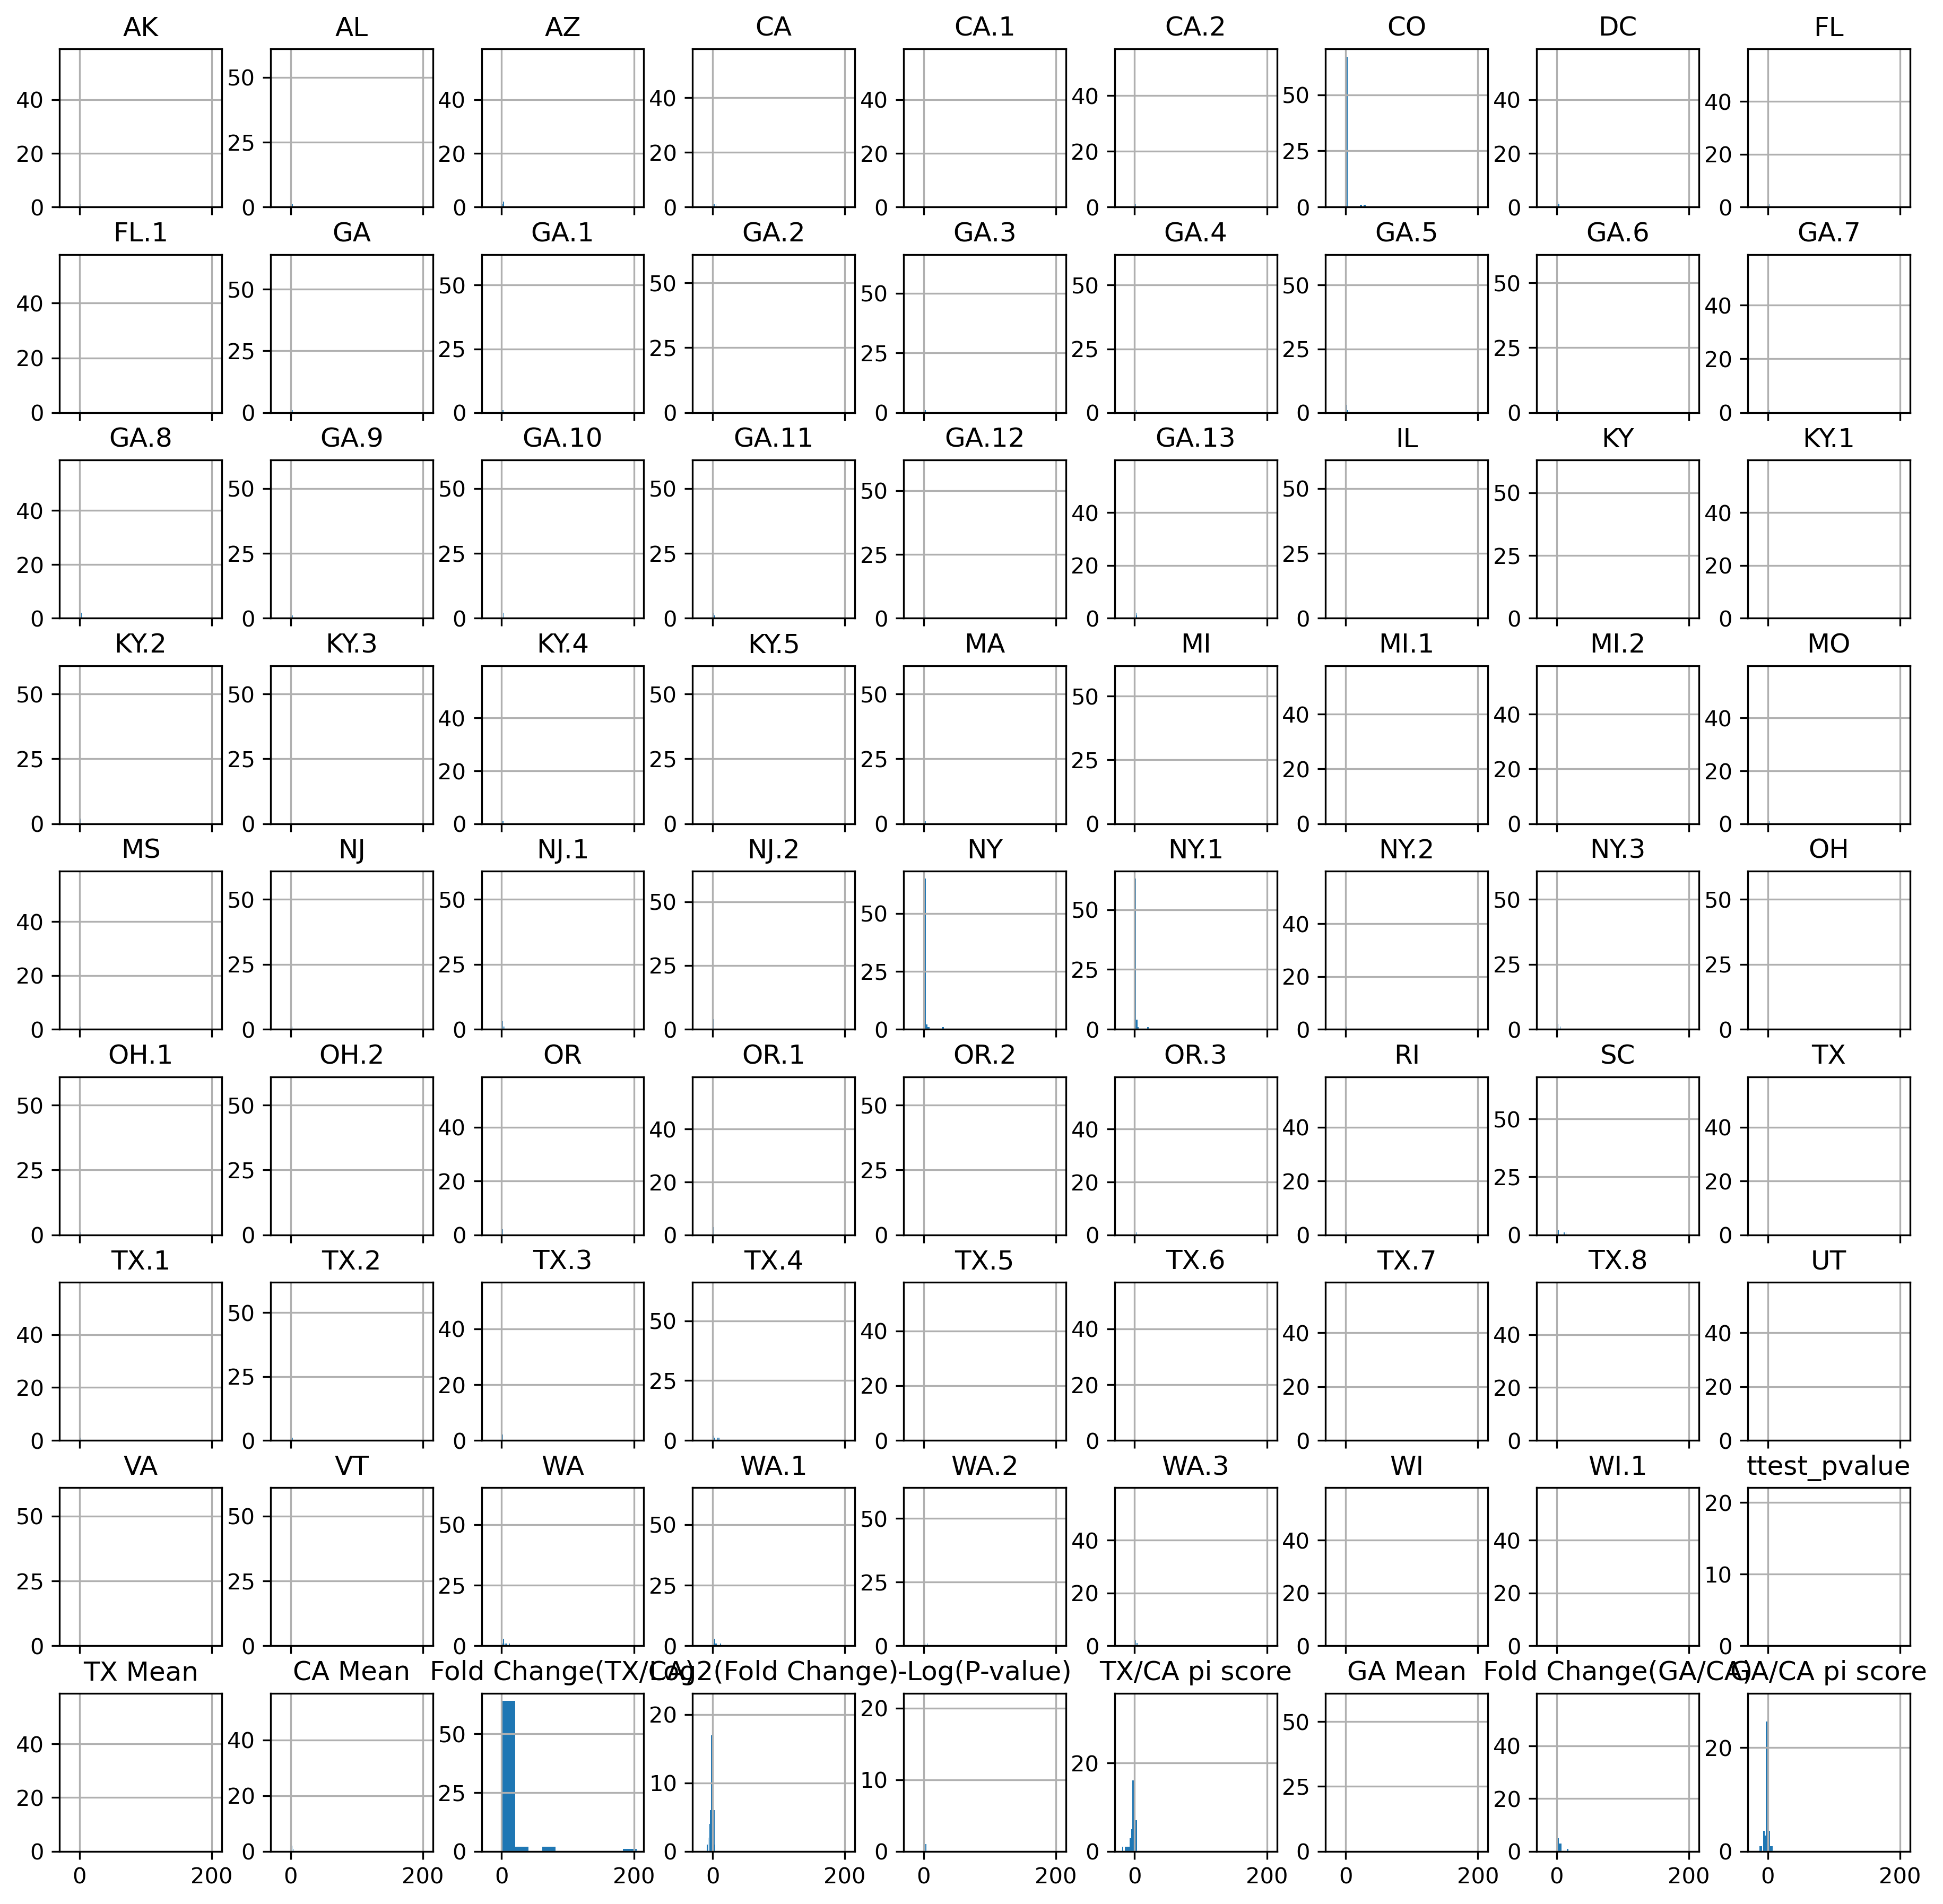

In [119]:
#View the distribution of each column
dfd.hist(figsize=(15,15), sharex = True)

In [120]:
#Use numpy to log2transform the data
df_cooler = np.log2(dfd) #log2transforms the data
df_cooler

/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


AK         AL         AZ  \
Chemical                                                                
1_1_1-Trichloroethane (¬µg/m3)        -3.796887  -3.969953  -3.628549   
1_1_2-Trichloroethane (¬µg/m3)       -11.338465 -11.243084 -11.338482   
1_1_2_2-Tetrachloroethane (¬µg/m3)   -10.217871 -12.297899 -15.756331   
1_2-Dibromo-3-Chloropropane (¬µg/m3) -19.538592 -19.538592 -19.538592   
1_3-Butadiene (¬µg/m3)                -2.340012  -3.927546  -3.727048   
...                                         ...        ...        ...   
Trichloroethylene (¬µg/m3)            -6.778786  -4.990309  -9.122880   
Triethylamine (¬µg/m3)                -9.049164  -9.934475  -8.437040   
Vinyl Acetate (¬µg/m3)               -13.934613 -14.401008 -13.083445   
Vinyl Chloride (¬µg/m3)              -13.068544 -10.988634 -14.695084   
Xylenes (Mixed Isomers) (¬µg/m3)       1.185147   0.210886   0.637694   

                                             CA       CA.1       CA.2  \
Chemical                                                                
1_1_1-Trichloroethane (¬µg/m3)        -3.691659  -3.958038   2.172166   
1_1_2-Trichloroethane (¬µg/m3)       -11.298838 -11.336614 -11.338501   
1_1_2_2-Tetrachloroethane (¬µg/m3)   -12.990007 -13.452792 -12.453104   
1_2-Dibromo-3-Chloropropane (¬µg/m3) -19.538592 -19.538592 -19.538592   
1_3-Butadiene (¬µg/m3)                -3.182316  -4.225048  -3.287228   
...                                         ...        ...        ...   
Trichloroethylene (¬µg/m3)            -3.454072  -4.509569  -3.557461   
Triethylamine (¬µg/m3)                -8.581037  -9.559866  -9.039308   
Vinyl Acetate (¬µg/m3)               -10.742733 -12.841998  -7.820916   
Vinyl Chloride (¬µg/m3)              -11.595995 -11.740161  -8.487379   
Xylenes (Mixed Isomers) (¬µg/m3)       1.419904   0.494467   1.162658   

                                             CO         DC         FL  \
Chemical                                                                
1_1_1-Trichloroethane (¬µg/m3)        -4.058894  -2.643089  -4.008687   
1_1_2-Trichloroethane (¬µg/m3)       -11.335073 -11.336866 -11.338495   
1_1_2_2-Tetrachloroethane (¬µg/m3)   -12.102761 -13.958841 -13.680923   
1_2-Dibromo-3-Chloropropane (¬µg/m3) -19.538592 -19.538592 -19.538592   
1_3-Butadiene (¬µg/m3)                -4.146058  -2.756964  -4.644116   
...                                         ...        ...        ...   
Trichloroethylene (¬µg/m3)           -11.242580  -7.015564 -10.876606   
Triethylamine (¬µg/m3)               -11.163244  -8.588743 -10.655512   
Vinyl Acetate (¬µg/m3)               -14.794828 -12.417910 -14.566769   
Vinyl Chloride (¬µg/m3)              -10.845807 -11.465921 -12.253406   
Xylenes (Mixed Isomers) (¬µg/m3)      -0.488981   1.143800  -0.391873   

                                           FL.1  ...  ttest_pvalue    TX Mean  \
Chemical                                         ...                            
1_1_1-Trichloroethane (¬µg/m3)        -3.798316  ...     -1.246646  -3.961042   
1_1_2-Trichloroethane (¬µg/m3)       -11.338500  ...     -1.169459 -11.235459   
1_1_2_2-Tetrachloroethane (¬µg/m3)    -9.355322  ...     -2.240647 -14.290875   
1_2-Dibromo-3-Chloropropane (¬µg/m3) -19.538592  ...     -1.575352 -19.538592   
1_3-Butadiene (¬µg/m3)                -3.817412  ...     -2.677746  -4.961310   
...                                         ...  ...           ...        ...   
Trichloroethylene (¬µg/m3)            -7.725666  ...     -4.488439  -8.729883   
Triethylamine (¬µg/m3)                -8.880263  ...     -4.011676 -11.063681   
Vinyl Acetate (¬µg/m3)               -13.942330  ...     -1.521287  -6.467174   
Vinyl Chloride (¬µg/m3)               -7.539889  ...     -0.796916  -9.737996   
Xylenes (Mixed Isomers) (¬µg/m3)       0.456950  ...     -4.067419  -1.291123   

                                        CA Mean  Fold Change(TX/CA)  \
Chemical                                                              

In [121]:
#Drop any datasets that contain NaN after log2 transformation
df_chill = df_cooler.dropna()
df_chill

AK         AL  \
Chemical                                                                   
1_1_2-Trichloroethane (¬µg/m3)                     -11.338465 -11.243084   
Acrylonitrile (¬µg/m3)                             -11.581530  -7.335355   
Benzyl Chloride (¬µg/m3)                           -12.761186 -12.021566   
Biphenyl (¬µg/m3)                                  -14.079737 -15.005080   
Bromoform (¬µg/m3)                                  -6.643851  -6.642323   
...                                                       ...        ...   
Hydrogen Fluoride (Hydrofluoric Acid) (¬µg/m3)     -12.821312  -5.180682   
Mercury Compounds (¬µg/m3)                         -11.688555  -7.789163   
Methanol (¬µg/m3)                                    0.494909   0.859471   
Phenol (¬µg/m3)                                     -4.759597  -3.503340   
Propylene Dichloride (1_2-Dichloropropane) (¬µg... -11.772824 -13.838581   

                                                           AZ         CA  \
Chemical                                                                   
1_1_2-Trichloroethane (¬µg/m3)                     -11.338482 -11.298838   
Acrylonitrile (¬µg/m3)                             -13.671315 -12.178764   
Benzyl Chloride (¬µg/m3)                           -12.767965 -12.768328   
Biphenyl (¬µg/m3)                                  -13.368504 -33.219281   
Bromoform (¬µg/m3)                                  -6.643856  -6.643856   
...                                                       ...        ...   
Hydrogen Fluoride (Hydrofluoric Acid) (¬µg/m3)      -9.697363 -12.700307   
Mercury Compounds (¬µg/m3)                          -9.951667  -9.285916   
Methanol (¬µg/m3)                                    1.543280   0.343326   
Phenol (¬µg/m3)                                     -7.187851  -6.834015   
Propylene Dichloride (1_2-Dichloropropane) (¬µg... -17.670790 -15.855882   

                                                         CA.1       CA.2  \
Chemical                                                                   
1_1_2-Trichloroethane (¬µg/m3)                     -11.336614 -11.338501   
Acrylonitrile (¬µg/m3)                             -12.356452 -11.492253   
Benzyl Chloride (¬µg/m3)                           -12.768333 -12.767263   
Biphenyl (¬µg/m3)                                  -24.267996 -12.059035   
Bromoform (¬µg/m3)                                  -6.643856  -6.643856   
...                                                       ...        ...   
Hydrogen Fluoride (Hydrofluoric Acid) (¬µg/m3)     -10.158616 -12.673680   
Mercury Compounds (¬µg/m3)                          -9.697775  -9.408642   
Methanol (¬µg/m3)                                   -0.067237  -0.436441   
Phenol (¬µg/m3)                                     -6.625318  -4.839170   
Propylene Dichloride (1_2-Dichloropropane) (¬µg... -16.258555 -16.038488   

                                                           CO         DC  \
Chemical                                                                   
1_1_2-Trichloroethane (¬µg/m3)                     -11.335073 -11.336866   
Acrylonitrile (¬µg/m3)                             -11.301772 -11.592856   
Benzyl Chloride (¬µg/m3)                           -12.764003 -12.639003   
Biphenyl (¬µg/m3)                                  -14.993725 -12.803489   
Bromoform (¬µg/m3)                                  -6.643853  -6.643773   
...                                                       ...        ...   
Hydrogen Fluoride (Hydrofluoric Acid) (¬µg/m3)     -13.396222 -11.291583   
Mercury Compounds (¬µg/m3)                          -9.093171  -9.186627   
Methanol (¬µg/m3)                                    0.533852   1.385824   
Phenol (¬µg/m3)                                      4.932646  -4.675584   
Propylene Dichloride (1_2-Dichloropropane) (¬µg... -17.271119 -12.386700   

                                                           FL       FL.1  ...  \
Chemical              

array([[<AxesSubplot:title={'center':'AK'}>,
        <AxesSubplot:title={'center':'AL'}>,
        <AxesSubplot:title={'center':'AZ'}>,
        <AxesSubplot:title={'center':'CA'}>,
        <AxesSubplot:title={'center':'CA.1'}>,
        <AxesSubplot:title={'center':'CA.2'}>,
        <AxesSubplot:title={'center':'CO'}>,
        <AxesSubplot:title={'center':'DC'}>,
        <AxesSubplot:title={'center':'FL'}>],
       [<AxesSubplot:title={'center':'FL.1'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA.1'}>,
        <AxesSubplot:title={'center':'GA.2'}>,
        <AxesSubplot:title={'center':'GA.3'}>,
        <AxesSubplot:title={'center':'GA.4'}>,
        <AxesSubplot:title={'center':'GA.5'}>,
        <AxesSubplot:title={'center':'GA.6'}>,
        <AxesSubplot:title={'center':'GA.7'}>],
       [<AxesSubplot:title={'center':'GA.8'}>,
        <AxesSubplot:title={'center':'GA.9'}>,
        <AxesSubplot:title={'center':'GA.10'}>,
        <AxesSubplot:title

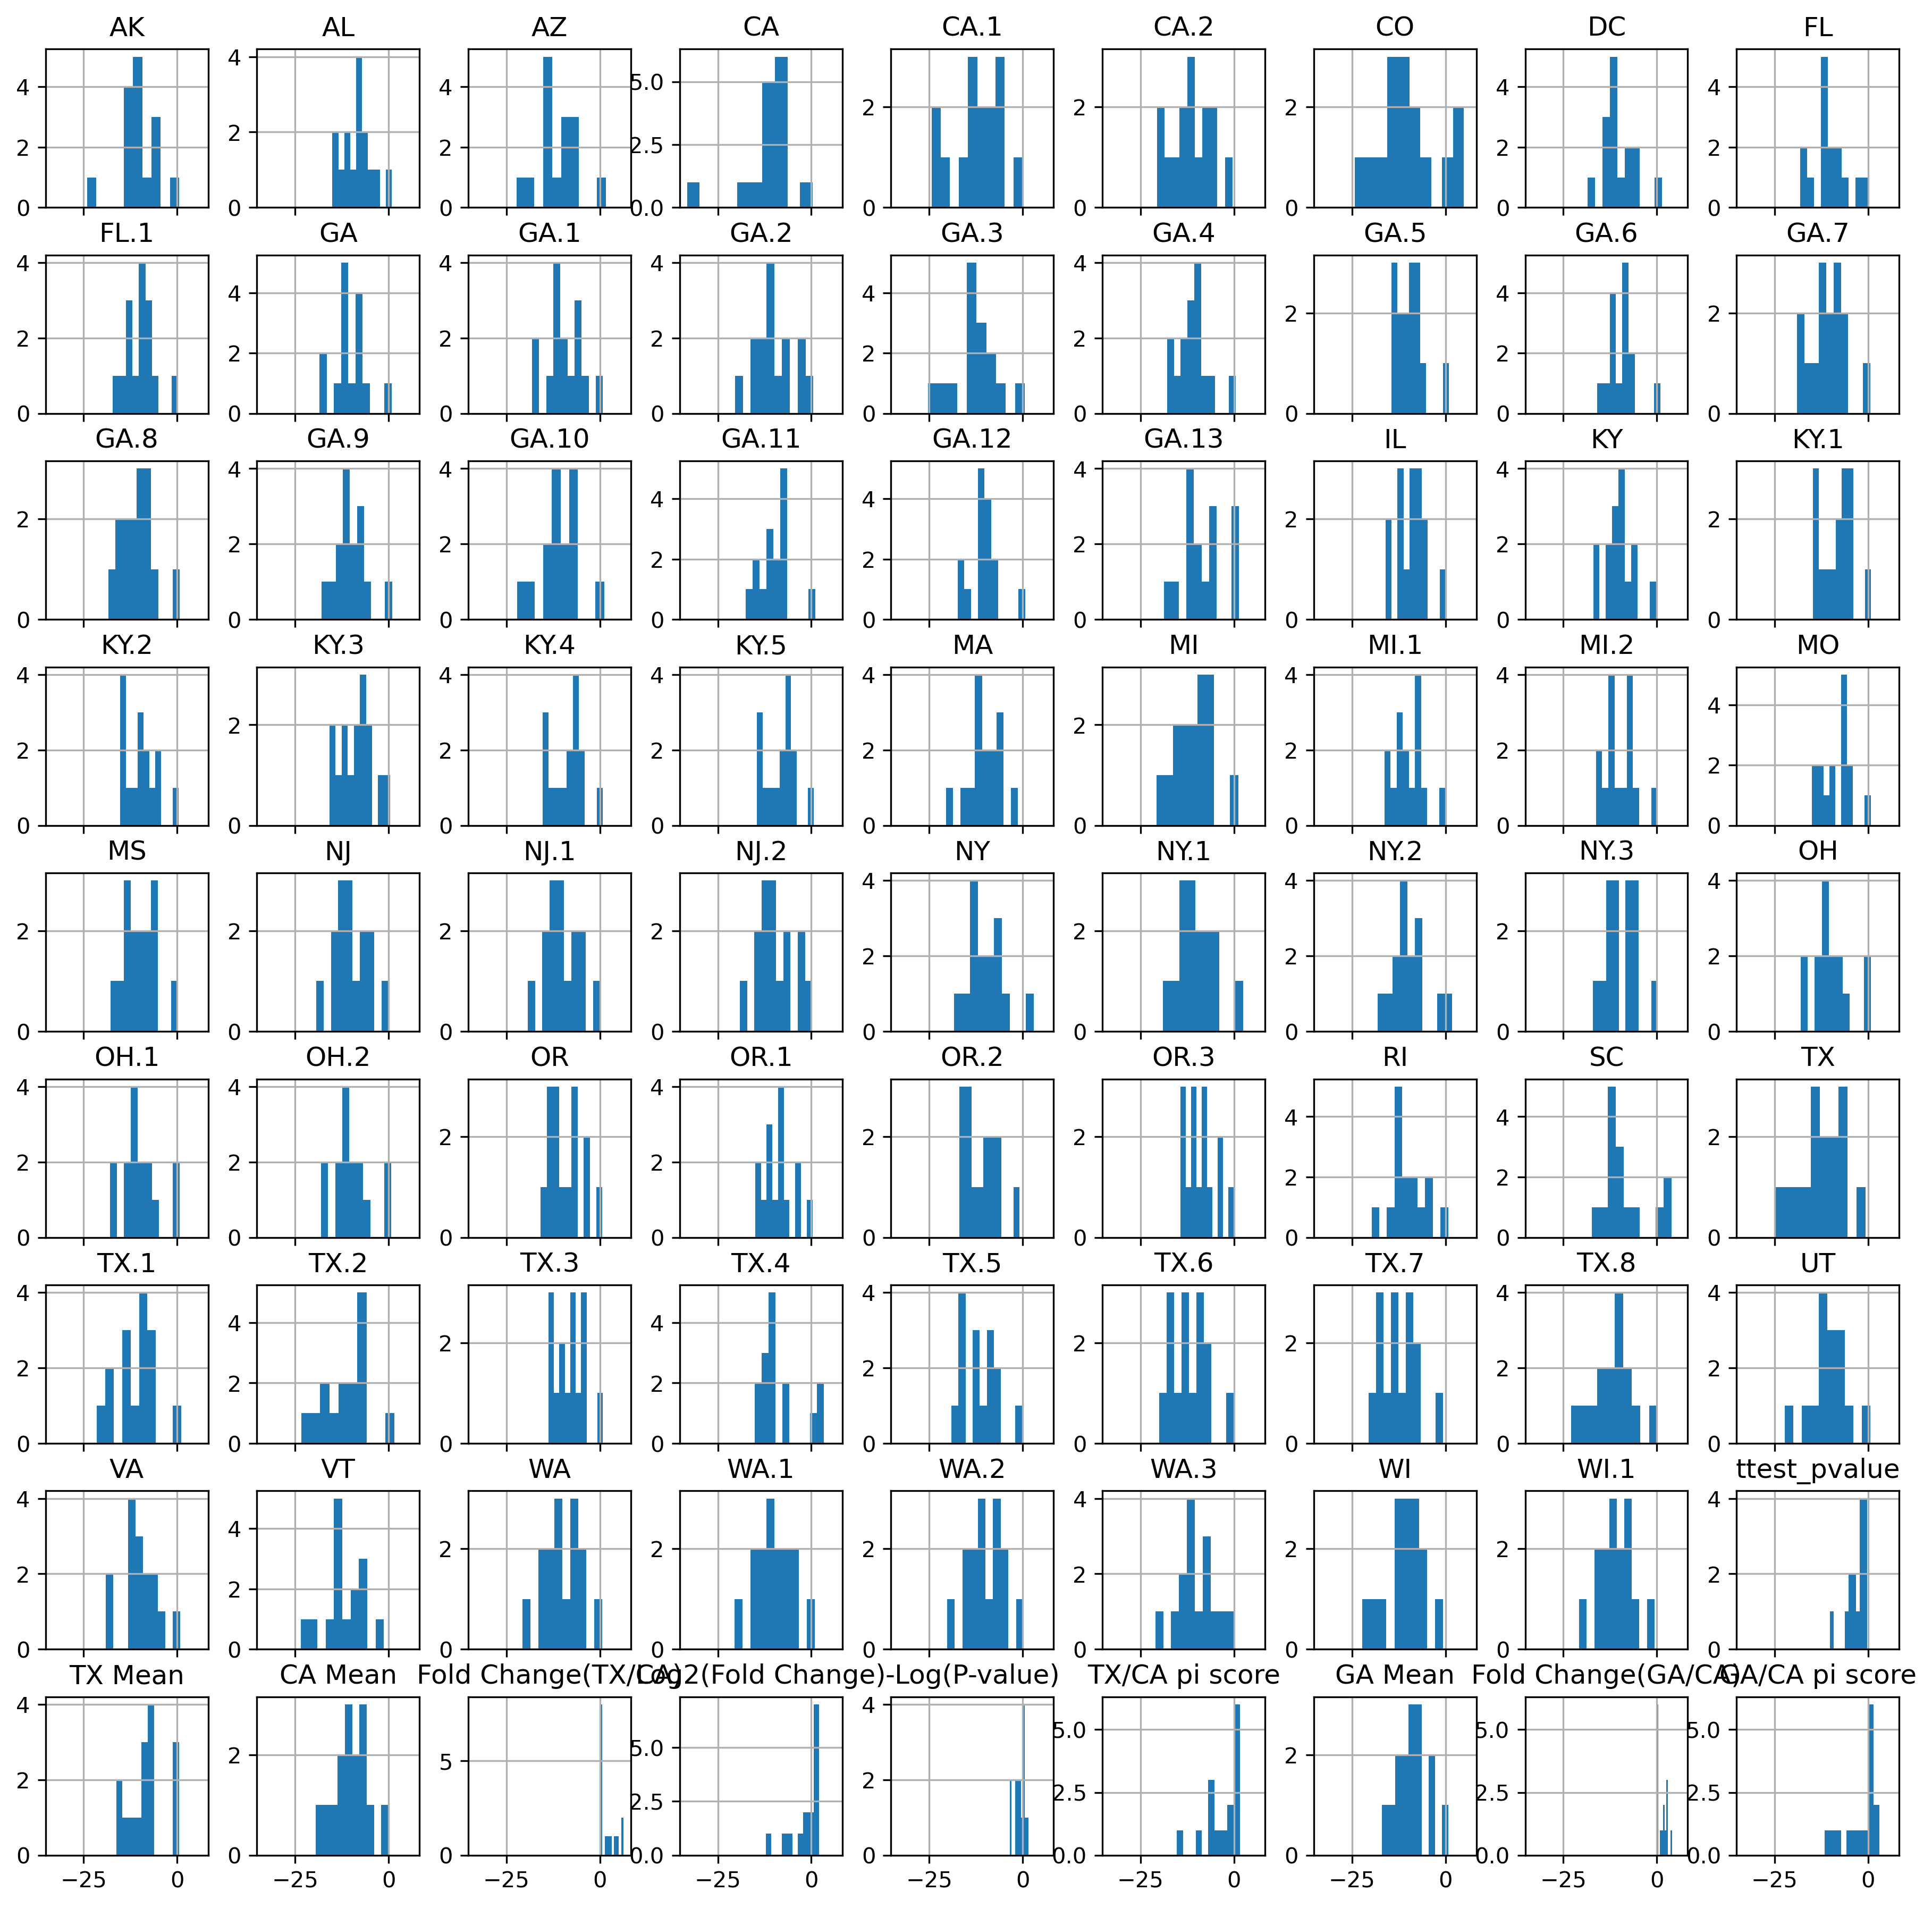

In [122]:
#View the distribution of each column
df_chill.hist(figsize=(15,15), sharex = True)

# Analysis on Transformed Data

In [123]:
# reshape the d dataframe suitable for statsmodels package 
df_melt2 = pd.melt(df_chill.reset_index(), id_vars=['Chemical'], value_vars=['AK', 'AL', 'AZ', 'CA', 'CO', 'DC', 'FL','GA', 'IL', 'KY','MA','MI','MO', 'MS', 'NJ', 'NY', 'OH', 'OR', 'RI', 'SC', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI'])


In [68]:
# replace column names
df_melt2.columns = ['index', 'group', 'value']
df_melt2

index group      value
0           1_1_1-Trichloroethane (¬µg/m3)    AK  -3.796887
1           1_1_2-Trichloroethane (¬µg/m3)    AK -11.338465
2       1_1_2_2-Tetrachloroethane (¬µg/m3)    AK -10.217871
3     1_2-Dibromo-3-Chloropropane (¬µg/m3)    AK -19.538592
4                   1_3-Butadiene (¬µg/m3)    AK  -2.340012
...                                    ...   ...        ...
1815            Trichloroethylene (¬µg/m3)    WI  -7.481356
1816                Triethylamine (¬µg/m3)    WI -11.758058
1817                Vinyl Acetate (¬µg/m3)    WI -14.701896
1818               Vinyl Chloride (¬µg/m3)    WI -12.733229
1819      Xylenes (Mixed Isomers) (¬µg/m3)    WI  -1.373673

[1820 rows x 3 columns]

/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
 

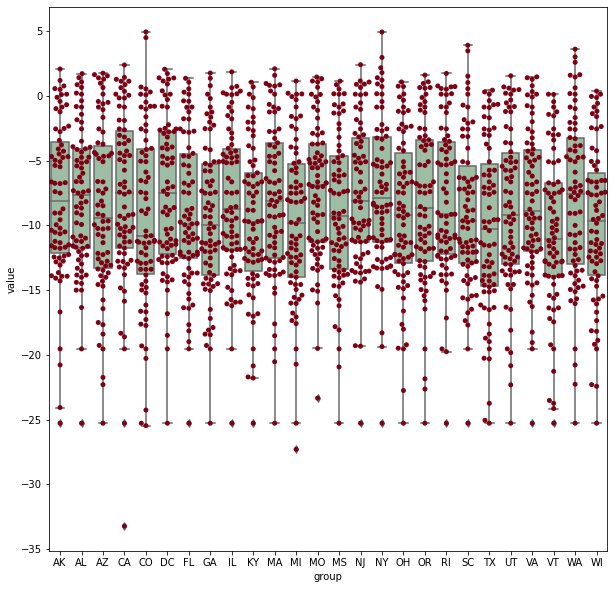

In [73]:
# generate a boxplot to see the data distribution
plt.figure(figsize=(10, 10))
ax = sns.boxplot(x='group', y='value', data=df_melt2, color='#99c2a2')
ax = sns.swarmplot(x="group", y="value", data=df_melt2, color='#7d0013')
plt.show()

In [70]:
# ANOVA table using bioinfokit v1.0.3 or later 
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(group)')
res.anova_summary
# output (ANOVA F and p value)

df       sum_sq   mean_sq         F    PR(>F)
C(group)    25.0    77.010318  3.080413  1.580018  0.034195
Residual  1794.0  3497.593008  1.949606       NaN       NaN

In [71]:
#Set the max rows displayed in pandas to 10
pd.set_option('display.max_rows', None)


In [32]:
#Set the max rows displayed in pandas to 10
pd.set_option('display.max_rows', 10)

<AxesSubplot:xlabel='STATE', ylabel='STATE'>

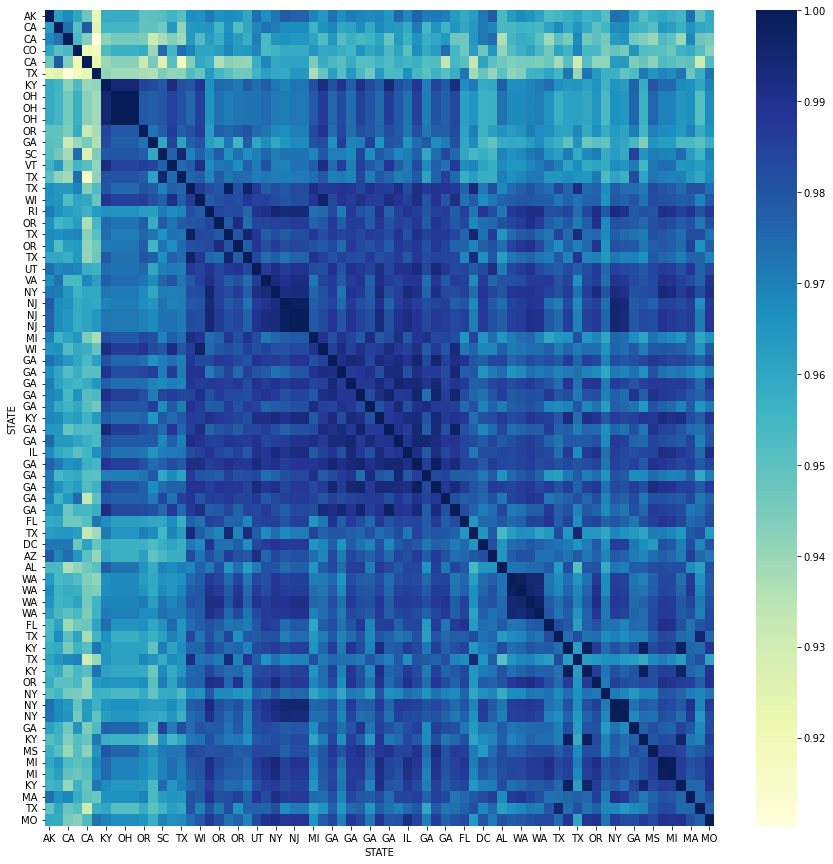

In [272]:
#view a correlation clusterplot of the data if you like that sort of thing

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(cluster_corr(df_chill.corr()), cmap='YlGnBu', ax=ax)

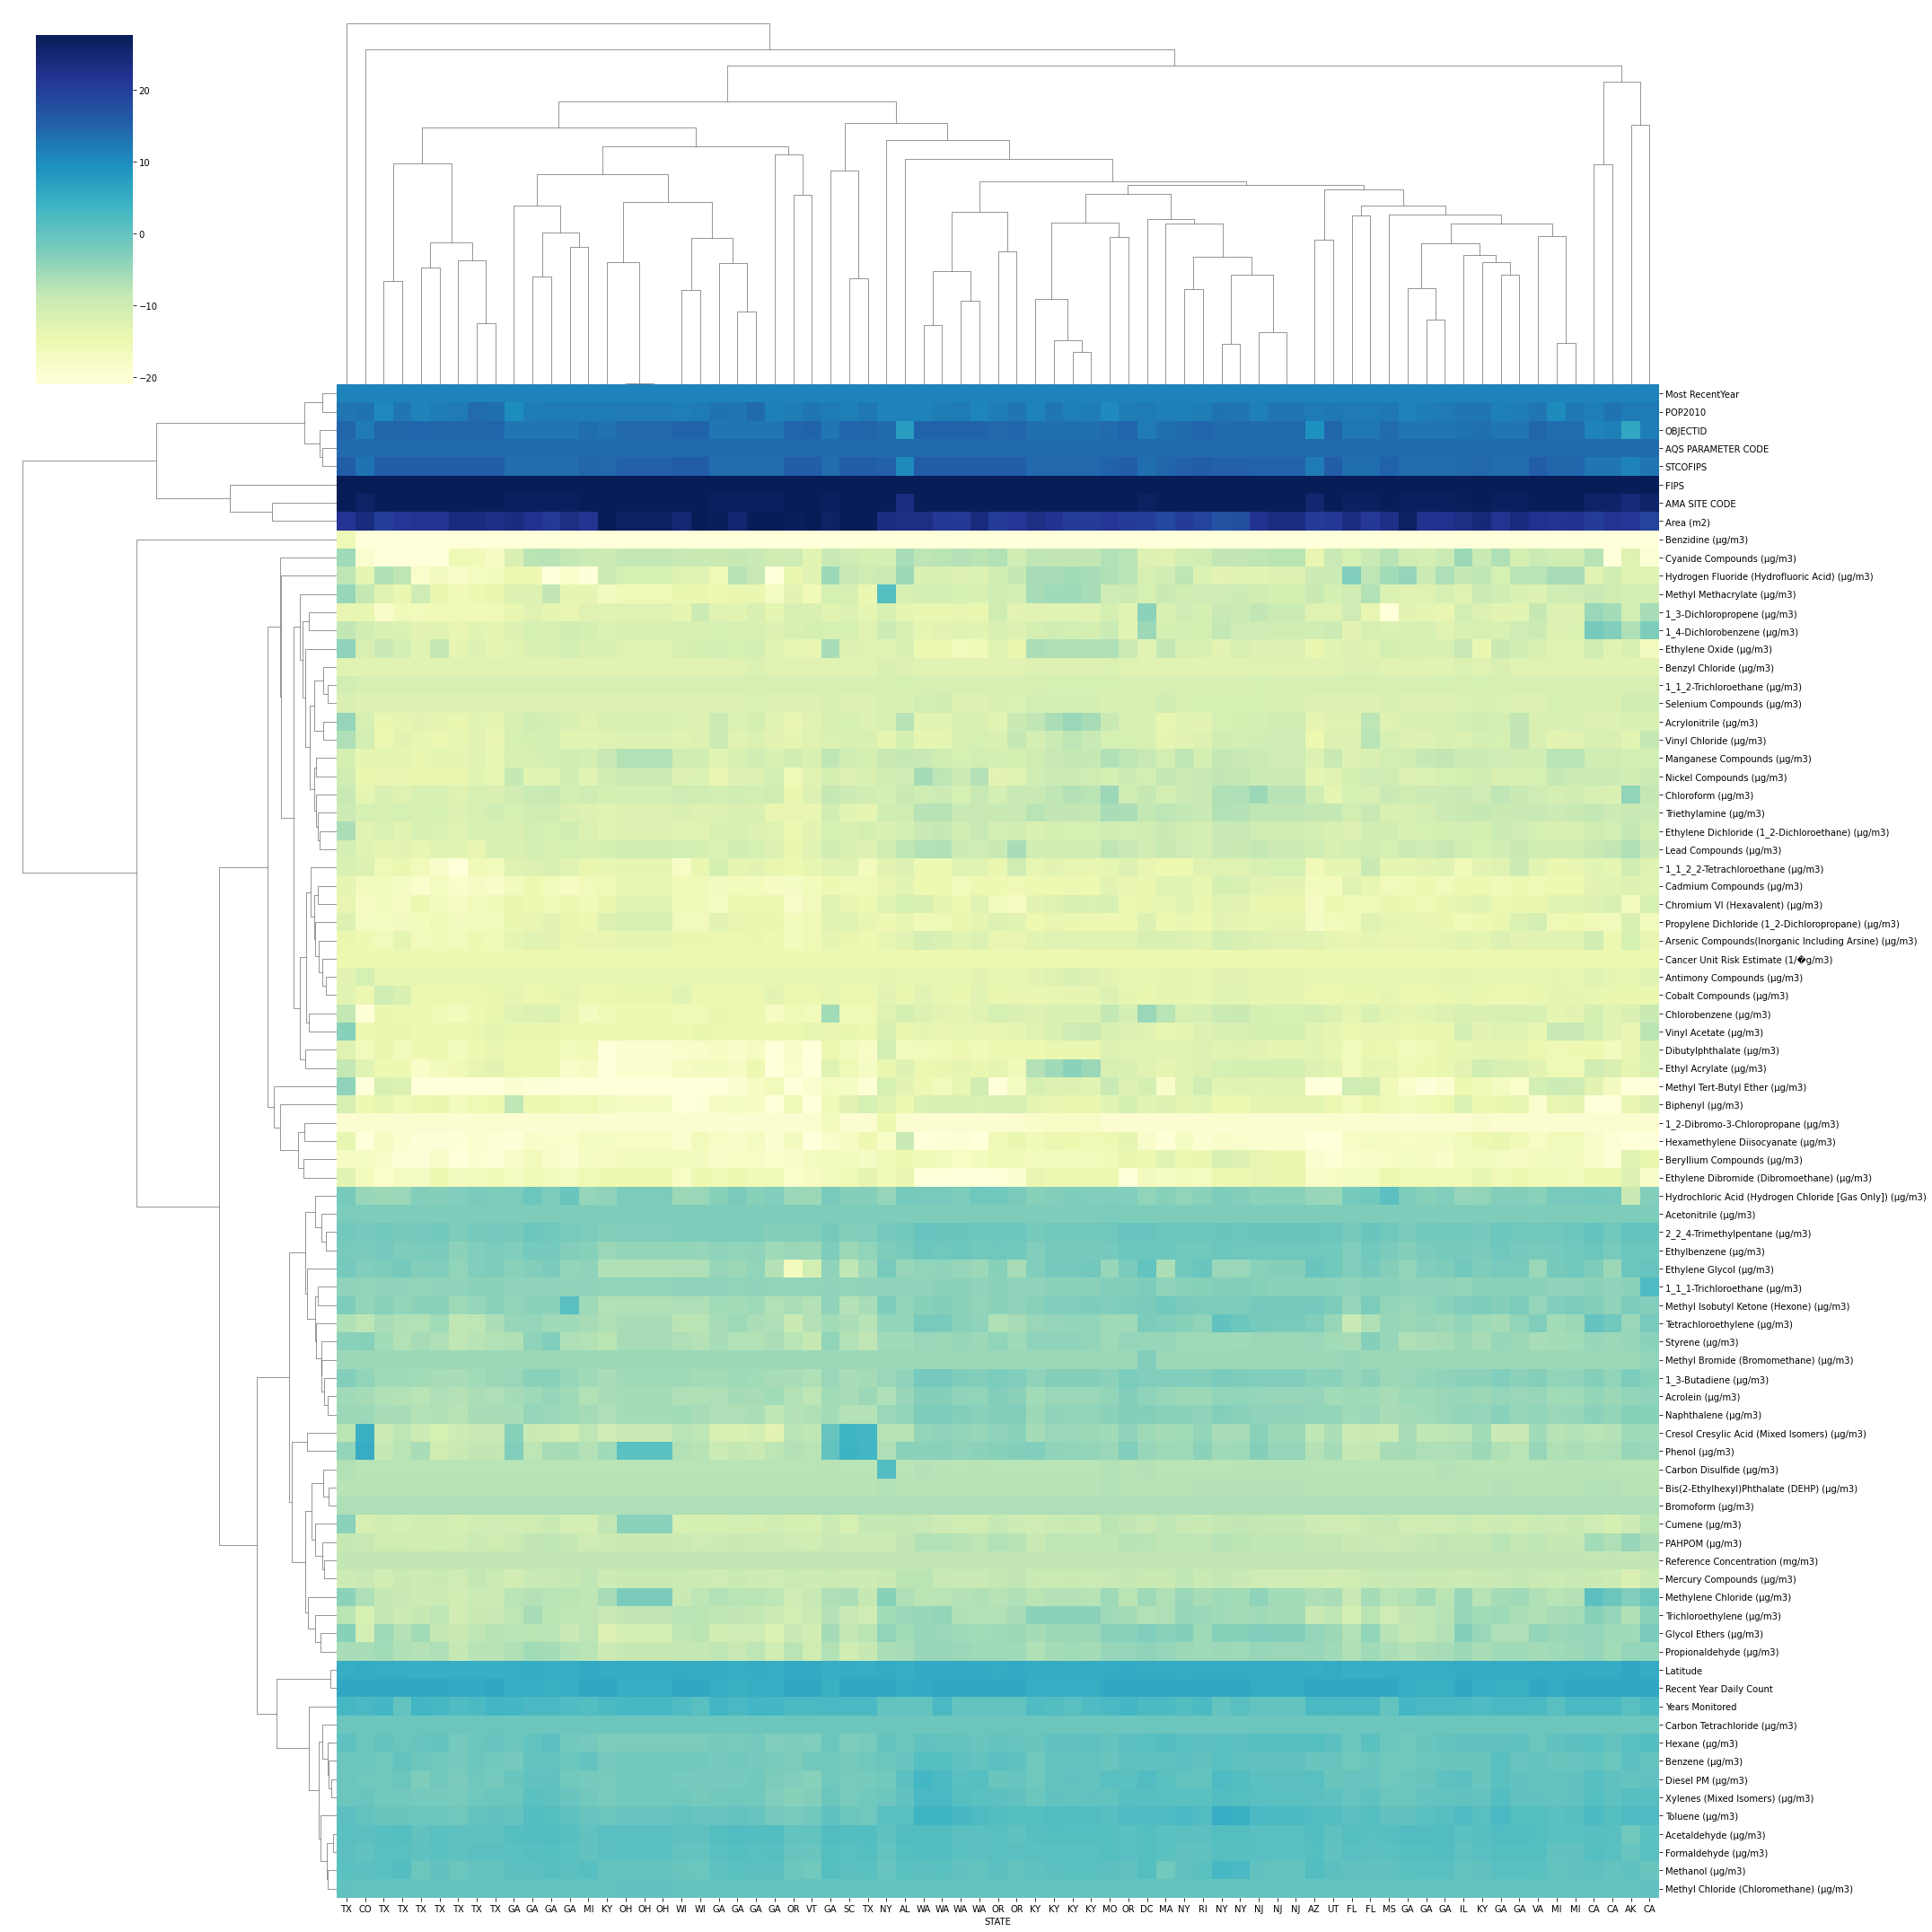

In [273]:
#heirarchical clustering of dataset
sns.clustermap(df_chill, robust = True, figsize=(30,30), cmap = "YlGnBu")

In [274]:
#Set the max rows displayed in pandas to no max
pd.set_option('display.max_rows', None)

In [275]:
#View the top 15 rows
df_chill.head(15)

STATE                                       AK         AL         AZ  \
OBJECTID                              5.857981   7.523562   9.269127   
AMA SITE CODE                        24.267853  23.355886  25.258537   
Latitude                              5.935598   5.069032   5.066250   
AQS PARAMETER CODE                   14.065164  14.065164  14.065164   
Cancer Unit Risk Estimate (1/�g/m3) -14.844106 -14.844106 -14.844106   
Reference Concentration (mg/m3)      -8.380822  -8.380822  -8.380822   
Most RecentYear                      10.975131  10.974415  10.975131   
Recent Year Daily Count               5.954196   5.392317   5.857981   
Years Monitored                       1.000000   0.000000   2.584963   
STCOFIPS                             10.980140  10.067434  11.970465   
FIPS                                 30.911709  29.999010  31.902073   
POP2010                              11.998590  11.081483  11.913637   
Area (m2)                            21.280212  23.078668  20.529232   
1_1_1-Trichloroethane (µg/m3)        -3.796887  -3.969953  -3.628549   
1_1_2-Trichloroethane (µg/m3)       -11.338465 -11.243084 -11.338482   

STATE                                       CA         CA         CA  \
OBJECTID                             11.097374  11.469642  11.825356   
AMA SITE CODE                        25.847355  25.854195  25.858754   
Latitude                              5.090286   5.087445   5.222978   
AQS PARAMETER CODE                   14.065164  14.065164  14.065164   
Cancer Unit Risk Estimate (1/�g/m3) -14.844106 -14.844106 -14.844106   
Reference Concentration (mg/m3)      -8.380822  -8.380822  -8.380822   
Most RecentYear                      10.975131  10.975131  10.975131   
Recent Year Daily Count               5.857981   5.857981   5.882643   
Years Monitored                       2.584963   2.584963   2.321928   
STCOFIPS                             12.559616  12.566292  12.571042   
FIPS                                 32.491234  32.497870  32.502729   
POP2010                              11.610564  12.939763  11.992230   
Area (m2)                            20.432871  21.671158  19.316877   
1_1_1-Trichloroethane (µg/m3)        -3.691659  -3.958038   2.172166   
1_1_2-Trichloroethane (µg/m3)       -11.298838 -11.336614 -11.338501   

STATE                                       CO         DC         FL  \
OBJECTID                             12.106890  12.174926  12.396872   
AMA SITE CODE                        26.267317  26.713060  26.845332   
Latitude                              5.287777   5.282508   4.805584   
AQS PARAMETER CODE                   14.065164  14.065164  14.065164   
Cancer Unit Risk Estimate (1/�g/m3) -14.844106 -14.844106 -14.844106   
Reference Concentration (mg/m3)      -8.380822  -8.380822  -8.380822   
Most RecentYear                      10.975131  10.975131  10.975131   
Recent Year Daily Count               5.807355   5.906891   5.882643   
Years Monitored                       2.584963   2.321928   2.584963   
STCOFIPS                             12.979604  13.425347  13.557583   
FIPS                                 32.911173  33.356916  33.489153   
POP2010                              13.006677  12.085804  12.179287   
Area (m2)                            23.933766  20.025580  23.411165   
1_1_1-Trichloroethane (µg/m3)        -4.058894  -2.643089  -4.008687   
1_1_2-Trichloroethane (µg/m3)       -11.335073 -11.336866 -11.338495   

STATE                                       FL  ...         TX         UT  \
OBJECTID                             12.474973  ...  14.717462  14.723874   
AMA SITE CODE                        26.850790  ...  28.852785  28.868530   
Latitude                              4.799608  ...   4.781951   5.354134   
AQS PARAMETER CODE                   14.065164  ...  14.065164  14.065164   
Cancer Unit Risk Estimate (1/�g/m3) -14.844106  ... -14.844106 -14.844106   
Reference Concentration (mg/m3)      -8.380822  ...  -8.380822  -8.380822   
Mo

In [276]:
df_c = df_chill.reset_index()
df_c.head(5)

STATE                                index         AK         AL         AZ  \
0                                 OBJECTID   5.857981   7.523562   9.269127   
1                            AMA SITE CODE  24.267853  23.355886  25.258537   
2                                 Latitude   5.935598   5.069032   5.066250   
3                       AQS PARAMETER CODE  14.065164  14.065164  14.065164   
4      Cancer Unit Risk Estimate (1/�g/m3) -14.844106 -14.844106 -14.844106   

STATE         CA         CA         CA         CO         DC         FL  ...  \
0      11.097374  11.469642  11.825356  12.106890  12.174926  12.396872  ...   
1      25.847355  25.854195  25.858754  26.267317  26.713060  26.845332  ...   
2       5.090286   5.087445   5.222978   5.287777   5.282508   4.805584  ...   
3      14.065164  14.065164  14.065164  14.065164  14.065164  14.065164  ...   
4     -14.844106 -14.844106 -14.844106 -14.844106 -14.844106 -14.844106  ...   

STATE         TX         UT         VA         VT         WA         WA  \
0      14.717462  14.723874  14.740308  14.766011  14.791468  14.795380   
1      28.852785  28.868530  28.928381  28.897555  28.982315  28.982315   
2       4.781951   5.354134   5.230993   5.476654   5.571669   5.571930   
3      14.065164  14.065164  14.065164  14.065164  14.065164  14.065164   
4     -14.844106 -14.844106 -14.844106 -14.844106 -14.844106 -14.844106   

STATE         WA         WA         WI         WI  
0      14.801355  14.804635  14.820727  14.824213  
1      28.982859  28.982859  29.035564  29.035564  
2       5.560299   5.562719   5.441819   5.440786  
3      14.065164  14.065164  14.065164  14.065164  
4     -14.844106 -14.844106 -14.844106 -14.844106  

[5 rows x 72 columns]

In [277]:
#remove the non-chemical data (top 12 rows)
data = df_c.drop(range(0,13))
data.head(5)

STATE                                index         AK         AL         AZ  \
13           1_1_1-Trichloroethane (µg/m3)  -3.796887  -3.969953  -3.628549   
14           1_1_2-Trichloroethane (µg/m3) -11.338465 -11.243084 -11.338482   
15       1_1_2_2-Tetrachloroethane (µg/m3) -10.217871 -12.297899 -15.756331   
16     1_2-Dibromo-3-Chloropropane (µg/m3) -19.538592 -19.538592 -19.538592   
17                   1_3-Butadiene (µg/m3)  -2.340012  -3.927546  -3.727048   

STATE         CA         CA         CA         CO         DC         FL  ...  \
13     -3.691659  -3.958038   2.172166  -4.058894  -2.643089  -4.008687  ...   
14    -11.298838 -11.336614 -11.338501 -11.335073 -11.336866 -11.338495  ...   
15    -12.990007 -13.452792 -12.453104 -12.102761 -13.958841 -13.680923  ...   
16    -19.538592 -19.538592 -19.538592 -19.538592 -19.538592 -19.538592  ...   
17     -3.182316  -4.225048  -3.287228  -4.146058  -2.756964  -4.644116  ...   

STATE         TX         UT         VA         VT         WA         WA  \
13     -4.024433  -3.663098  -3.729315  -4.058518  -3.867341  -3.844676   
14    -11.321190 -11.338465 -11.333957 -11.338499 -11.337045 -11.338013   
15    -18.510574 -13.431661 -13.117491 -13.841973 -14.953249 -14.920073   
16    -19.538592 -19.538592 -19.538592 -19.538592 -19.538592 -19.538592   
17     -6.044512  -3.611149  -3.245413  -6.722766  -1.679886  -1.595628   

STATE         WA         WA         WI         WI  
13     -3.769895  -3.871994  -4.037055  -4.028913  
14    -11.338456 -11.337949 -11.338490 -11.338292  
15    -12.687180 -12.617442 -18.138880 -14.235909  
16    -19.538592 -19.538592 -19.538592 -19.538592  
17     -2.573657  -3.075451  -5.383198  -5.825888  

[5 rows x 72 columns]

In [278]:
#reset chemicals as column index
data_clean = data.set_index('index')
data_clean.describe()

STATE         AK         AL         AZ         CA         CA         CA  \
count  70.000000  70.000000  70.000000  70.000000  70.000000  70.000000   
mean   -8.057816  -7.870278  -8.851759  -7.809591  -8.528305  -7.689597   
std     6.074560   5.491665   6.593128   6.708394   6.501137   6.612921   
min   -25.276766 -25.276766 -25.276766 -33.219281 -25.276766 -25.444494   
25%   -12.138206 -11.753040 -13.309930 -11.712823 -12.764238 -11.865985   
50%    -8.118547  -7.645087  -9.445615  -7.516781  -7.940488  -7.633091   
75%    -3.530460  -4.102073  -3.888068  -2.732719  -3.884970  -2.549995   
max     2.071746   1.711477   1.745580   2.381266   1.411888   2.172166   

STATE         CO         DC         FL         FL  ...         TX         UT  \
count  70.000000  70.000000  70.000000  70.000000  ...  70.000000  70.000000   
mean   -9.416447  -7.543837  -9.019729  -8.185572  ... -10.113373  -8.861455   
std     6.998991   5.970758   5.866501   5.773897  ...   6.541529   6.269792   
min   -25.464393 -25.276766 -25.276766 -25.276766  ... -25.276766 -25.276766   
25%   -13.725269 -12.186069 -12.528029 -12.134282  ... -14.640711 -13.019765   
50%   -10.820611  -7.478671  -9.869584  -8.716398  ... -10.728946  -9.233132   
75%    -4.080685  -2.763684  -4.495754  -3.803090  ...  -5.208050  -4.427303   
max     4.932646   2.050149   1.351475   1.453684  ...   0.856128   1.542714   

STATE         VA         VT         WA         WA         WA         WA  \
count  70.000000  70.000000  70.000000  70.000000  70.000000  70.000000   
mean   -8.296290 -10.651337  -8.032959  -8.149014  -8.505747  -8.353839   
std     5.761957   6.153416   6.479378   6.526429   6.262386   6.057974   
min   -25.276766 -25.276766 -25.276766 -25.276766 -25.276766 -25.276766   
25%   -11.978381 -13.921672 -13.012921 -13.385483 -13.058356 -12.652678   
50%    -8.925001 -11.071676  -7.575386  -7.665178  -8.950897  -8.387339   
75%    -4.153187  -6.752554  -3.246803  -3.093104  -3.745552  -3.905083   
max     1.462948   0.124333   3.603687   3.685876   2.783652   2.096726   

STATE         WI         WI  
count  70.000000  70.000000  
mean   -9.895581  -9.747651  
std     6.061498   5.783709  
min   -25.276766 -25.276766  
25%   -13.817277 -14.054031  
50%    -9.693047  -9.724207  
75%    -5.929859  -6.183133  
max     0.365015   0.337054  

[8 rows x 71 columns]

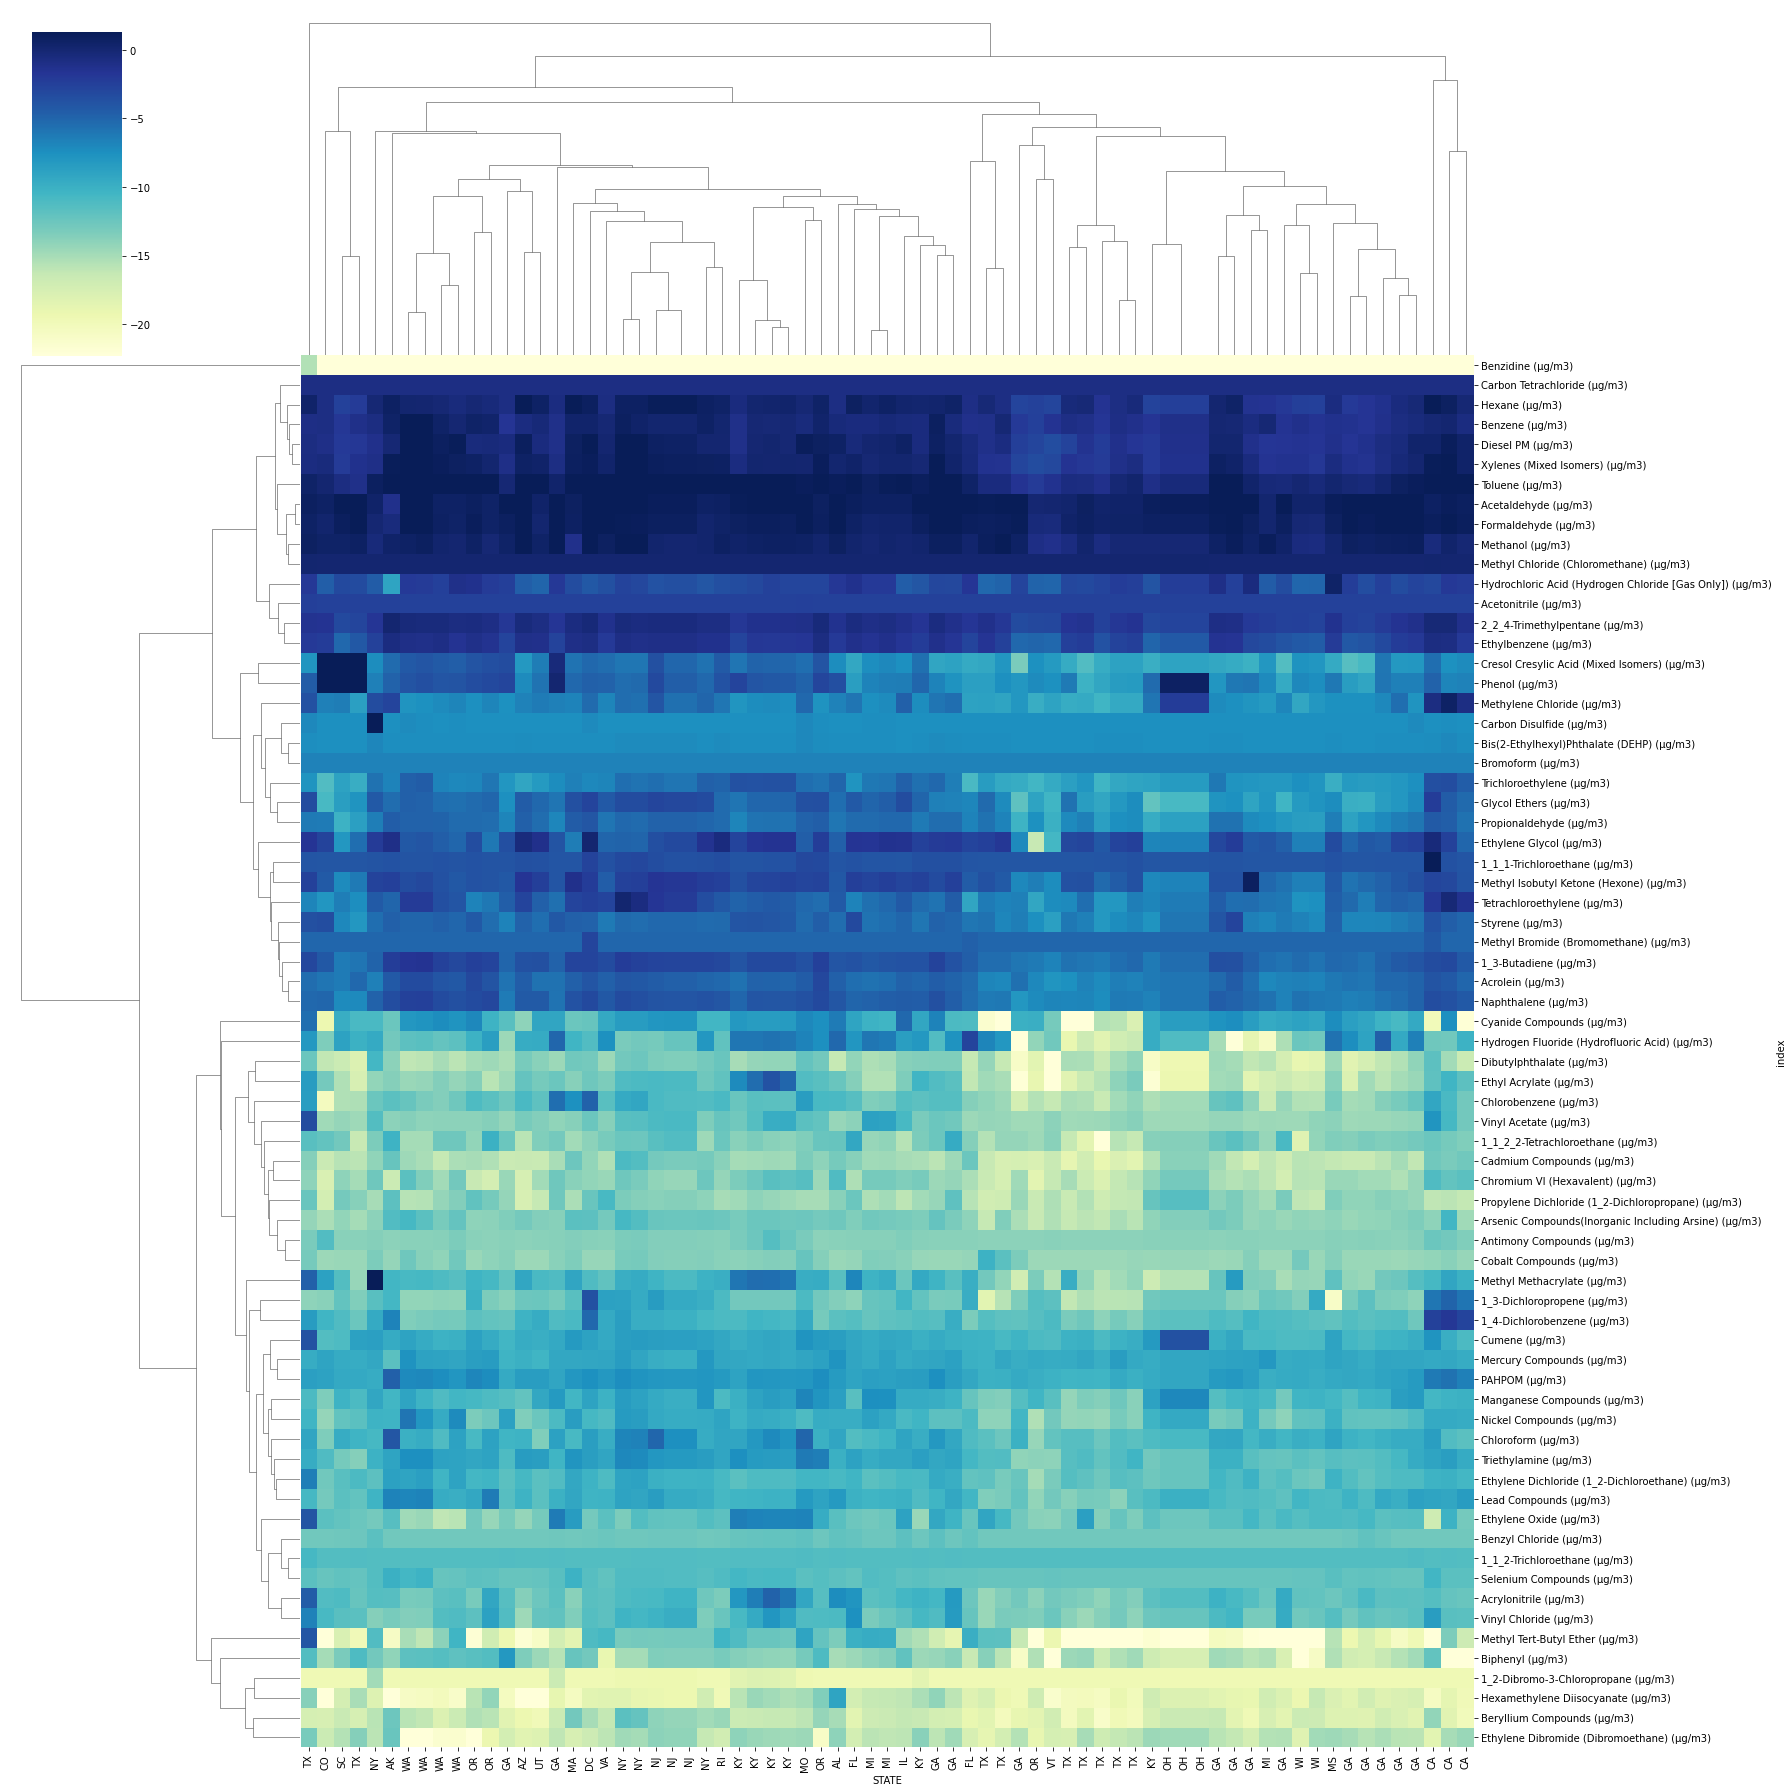

In [279]:
#heirarchical clustering of dataset
sns.clustermap(data_clean, robust = True, figsize=(25,25), cmap = "YlGnBu")

In [280]:
data_t = data_clean.transpose()
data_t.head(10)

index  1_1_1-Trichloroethane (µg/m3)  1_1_2-Trichloroethane (µg/m3)  \
STATE                                                                 
AK                         -3.796887                     -11.338465   
AL                         -3.969953                     -11.243084   
AZ                         -3.628549                     -11.338482   
CA                         -3.691659                     -11.298838   
CA                         -3.958038                     -11.336614   
CA                          2.172166                     -11.338501   
CO                         -4.058894                     -11.335073   
DC                         -2.643089                     -11.336866   
FL                         -4.008687                     -11.338495   
FL                         -3.798316                     -11.338500   

index  1_1_2_2-Tetrachloroethane (µg/m3)  1_2-Dibromo-3-Chloropropane (µg/m3)  \
STATE                                                                           
AK                            -10.217871                           -19.538592   
AL                            -12.297899                           -19.538592   
AZ                            -15.756331                           -19.538592   
CA                            -12.990007                           -19.538592   
CA                            -13.452792                           -19.538592   
CA                            -12.453104                           -19.538592   
CO                            -12.102761                           -19.538592   
DC                            -13.958841                           -19.538592   
FL                            -13.680923                           -19.538592   
FL                             -9.355322                           -19.538592   

index  1_3-Butadiene (µg/m3)  1_3-Dichloropropene (µg/m3)  \
STATE                                                       
AK                 -2.340012                   -10.648289   
AL                 -3.927546                   -13.544534   
AZ                 -3.727048                   -12.585733   
CA                 -3.182316                    -4.927887   
CA                 -4.225048                    -5.871919   
CA                 -3.287228                    -6.020687   
CO                 -4.146058                   -13.833838   
DC                 -2.756964                    -3.733962   
FL                 -4.644116                    -9.750723   
FL                 -3.817412                   -14.067893   

index  1_4-Dichlorobenzene (µg/m3)  2_2_4-Trimethylpentane (µg/m3)  \
STATE                                                                
AK                       -6.753184                        0.093651   
AL                      -11.692039                       -1.430071   
AZ                      -10.224865                       -0.507488   
CA                       -1.876380                       -0.163373   
CA                       -2.786328                       -1.221850   
CA                       -2.552992                       -0.171511   
CO                      -10.435447                       -1.615615   
DC                       -5.172656                       -0.288660   
FL                      -13.320547                       -1.792319   
FL                      -11.409585                       -0.608884   

index  Acetaldehyde (µg/m3)  Acetonitrile (µg/m3)  ...  \
STATE                                              ...   
AK                -1.229480             -2.556369  ...   
AL                 1.711477             -2.556387  ...   
AZ                 1.633853             -2.556380  ...   
CA                 1.122677             -2.556290  ...   
CA                 0.922019             -2.556393  ...   
CA                 0.768978             -2.548995  ...   
CO                 0.676393             -2.556393  ...   
DC                 1.375001             -2.555287  ...   
FL                 1

In [281]:
#Assign unique group numbers based upon the index (state) column 
data_t['group'] = data_t.groupby(['STATE']).ngroup()
data_t.head(10)

index  1_1_1-Trichloroethane (µg/m3)  1_1_2-Trichloroethane (µg/m3)  \
STATE                                                                 
AK                         -3.796887                     -11.338465   
AL                         -3.969953                     -11.243084   
AZ                         -3.628549                     -11.338482   
CA                         -3.691659                     -11.298838   
CA                         -3.958038                     -11.336614   
CA                          2.172166                     -11.338501   
CO                         -4.058894                     -11.335073   
DC                         -2.643089                     -11.336866   
FL                         -4.008687                     -11.338495   
FL                         -3.798316                     -11.338500   

index  1_1_2_2-Tetrachloroethane (µg/m3)  1_2-Dibromo-3-Chloropropane (µg/m3)  \
STATE                                                                           
AK                            -10.217871                           -19.538592   
AL                            -12.297899                           -19.538592   
AZ                            -15.756331                           -19.538592   
CA                            -12.990007                           -19.538592   
CA                            -13.452792                           -19.538592   
CA                            -12.453104                           -19.538592   
CO                            -12.102761                           -19.538592   
DC                            -13.958841                           -19.538592   
FL                            -13.680923                           -19.538592   
FL                             -9.355322                           -19.538592   

index  1_3-Butadiene (µg/m3)  1_3-Dichloropropene (µg/m3)  \
STATE                                                       
AK                 -2.340012                   -10.648289   
AL                 -3.927546                   -13.544534   
AZ                 -3.727048                   -12.585733   
CA                 -3.182316                    -4.927887   
CA                 -4.225048                    -5.871919   
CA                 -3.287228                    -6.020687   
CO                 -4.146058                   -13.833838   
DC                 -2.756964                    -3.733962   
FL                 -4.644116                    -9.750723   
FL                 -3.817412                   -14.067893   

index  1_4-Dichlorobenzene (µg/m3)  2_2_4-Trimethylpentane (µg/m3)  \
STATE                                                                
AK                       -6.753184                        0.093651   
AL                      -11.692039                       -1.430071   
AZ                      -10.224865                       -0.507488   
CA                       -1.876380                       -0.163373   
CA                       -2.786328                       -1.221850   
CA                       -2.552992                       -0.171511   
CO                      -10.435447                       -1.615615   
DC                       -5.172656                       -0.288660   
FL                      -13.320547                       -1.792319   
FL                      -11.409585                       -0.608884   

index  Acetaldehyde (µg/m3)  Acetonitrile (µg/m3)  ...  \
STATE                                              ...   
AK                -1.229480             -2.556369  ...   
AL                 1.711477             -2.556387  ...   
AZ                 1.633853             -2.556380  ...   
CA                 1.122677             -2.556290  ...   
CA                 0.922019             -2.556393  ...   
CA                 0.768978             -2.548995  ...   
CO                 0.676393             -2.556393  ...   
DC                 1.375001             -2.555287  ...   
FL                 1

## Note: This lets us know that they only measured 25 states and we can now illustrate these states as different colors on the clustermap...

In [282]:
#set the index
dfidgroups = data_t
dfidgroups.head(10)

index  1_1_1-Trichloroethane (µg/m3)  1_1_2-Trichloroethane (µg/m3)  \
STATE                                                                 
AK                         -3.796887                     -11.338465   
AL                         -3.969953                     -11.243084   
AZ                         -3.628549                     -11.338482   
CA                         -3.691659                     -11.298838   
CA                         -3.958038                     -11.336614   
CA                          2.172166                     -11.338501   
CO                         -4.058894                     -11.335073   
DC                         -2.643089                     -11.336866   
FL                         -4.008687                     -11.338495   
FL                         -3.798316                     -11.338500   

index  1_1_2_2-Tetrachloroethane (µg/m3)  1_2-Dibromo-3-Chloropropane (µg/m3)  \
STATE                                                                           
AK                            -10.217871                           -19.538592   
AL                            -12.297899                           -19.538592   
AZ                            -15.756331                           -19.538592   
CA                            -12.990007                           -19.538592   
CA                            -13.452792                           -19.538592   
CA                            -12.453104                           -19.538592   
CO                            -12.102761                           -19.538592   
DC                            -13.958841                           -19.538592   
FL                            -13.680923                           -19.538592   
FL                             -9.355322                           -19.538592   

index  1_3-Butadiene (µg/m3)  1_3-Dichloropropene (µg/m3)  \
STATE                                                       
AK                 -2.340012                   -10.648289   
AL                 -3.927546                   -13.544534   
AZ                 -3.727048                   -12.585733   
CA                 -3.182316                    -4.927887   
CA                 -4.225048                    -5.871919   
CA                 -3.287228                    -6.020687   
CO                 -4.146058                   -13.833838   
DC                 -2.756964                    -3.733962   
FL                 -4.644116                    -9.750723   
FL                 -3.817412                   -14.067893   

index  1_4-Dichlorobenzene (µg/m3)  2_2_4-Trimethylpentane (µg/m3)  \
STATE                                                                
AK                       -6.753184                        0.093651   
AL                      -11.692039                       -1.430071   
AZ                      -10.224865                       -0.507488   
CA                       -1.876380                       -0.163373   
CA                       -2.786328                       -1.221850   
CA                       -2.552992                       -0.171511   
CO                      -10.435447                       -1.615615   
DC                       -5.172656                       -0.288660   
FL                      -13.320547                       -1.792319   
FL                      -11.409585                       -0.608884   

index  Acetaldehyde (µg/m3)  Acetonitrile (µg/m3)  ...  \
STATE                                              ...   
AK                -1.229480             -2.556369  ...   
AL                 1.711477             -2.556387  ...   
AZ                 1.633853             -2.556380  ...   
CA                 1.122677             -2.556290  ...   
CA                 0.922019             -2.556393  ...   
CA                 0.768978             -2.548995  ...   
CO                 0.676393             -2.556393  ...   
DC                 1.375001             -2.555287  ...   
FL                 1

Text(0.5, 1.3, 'Hierarchical Clustering of USA States by EPA Measured Atmospheric Chemical Composition')

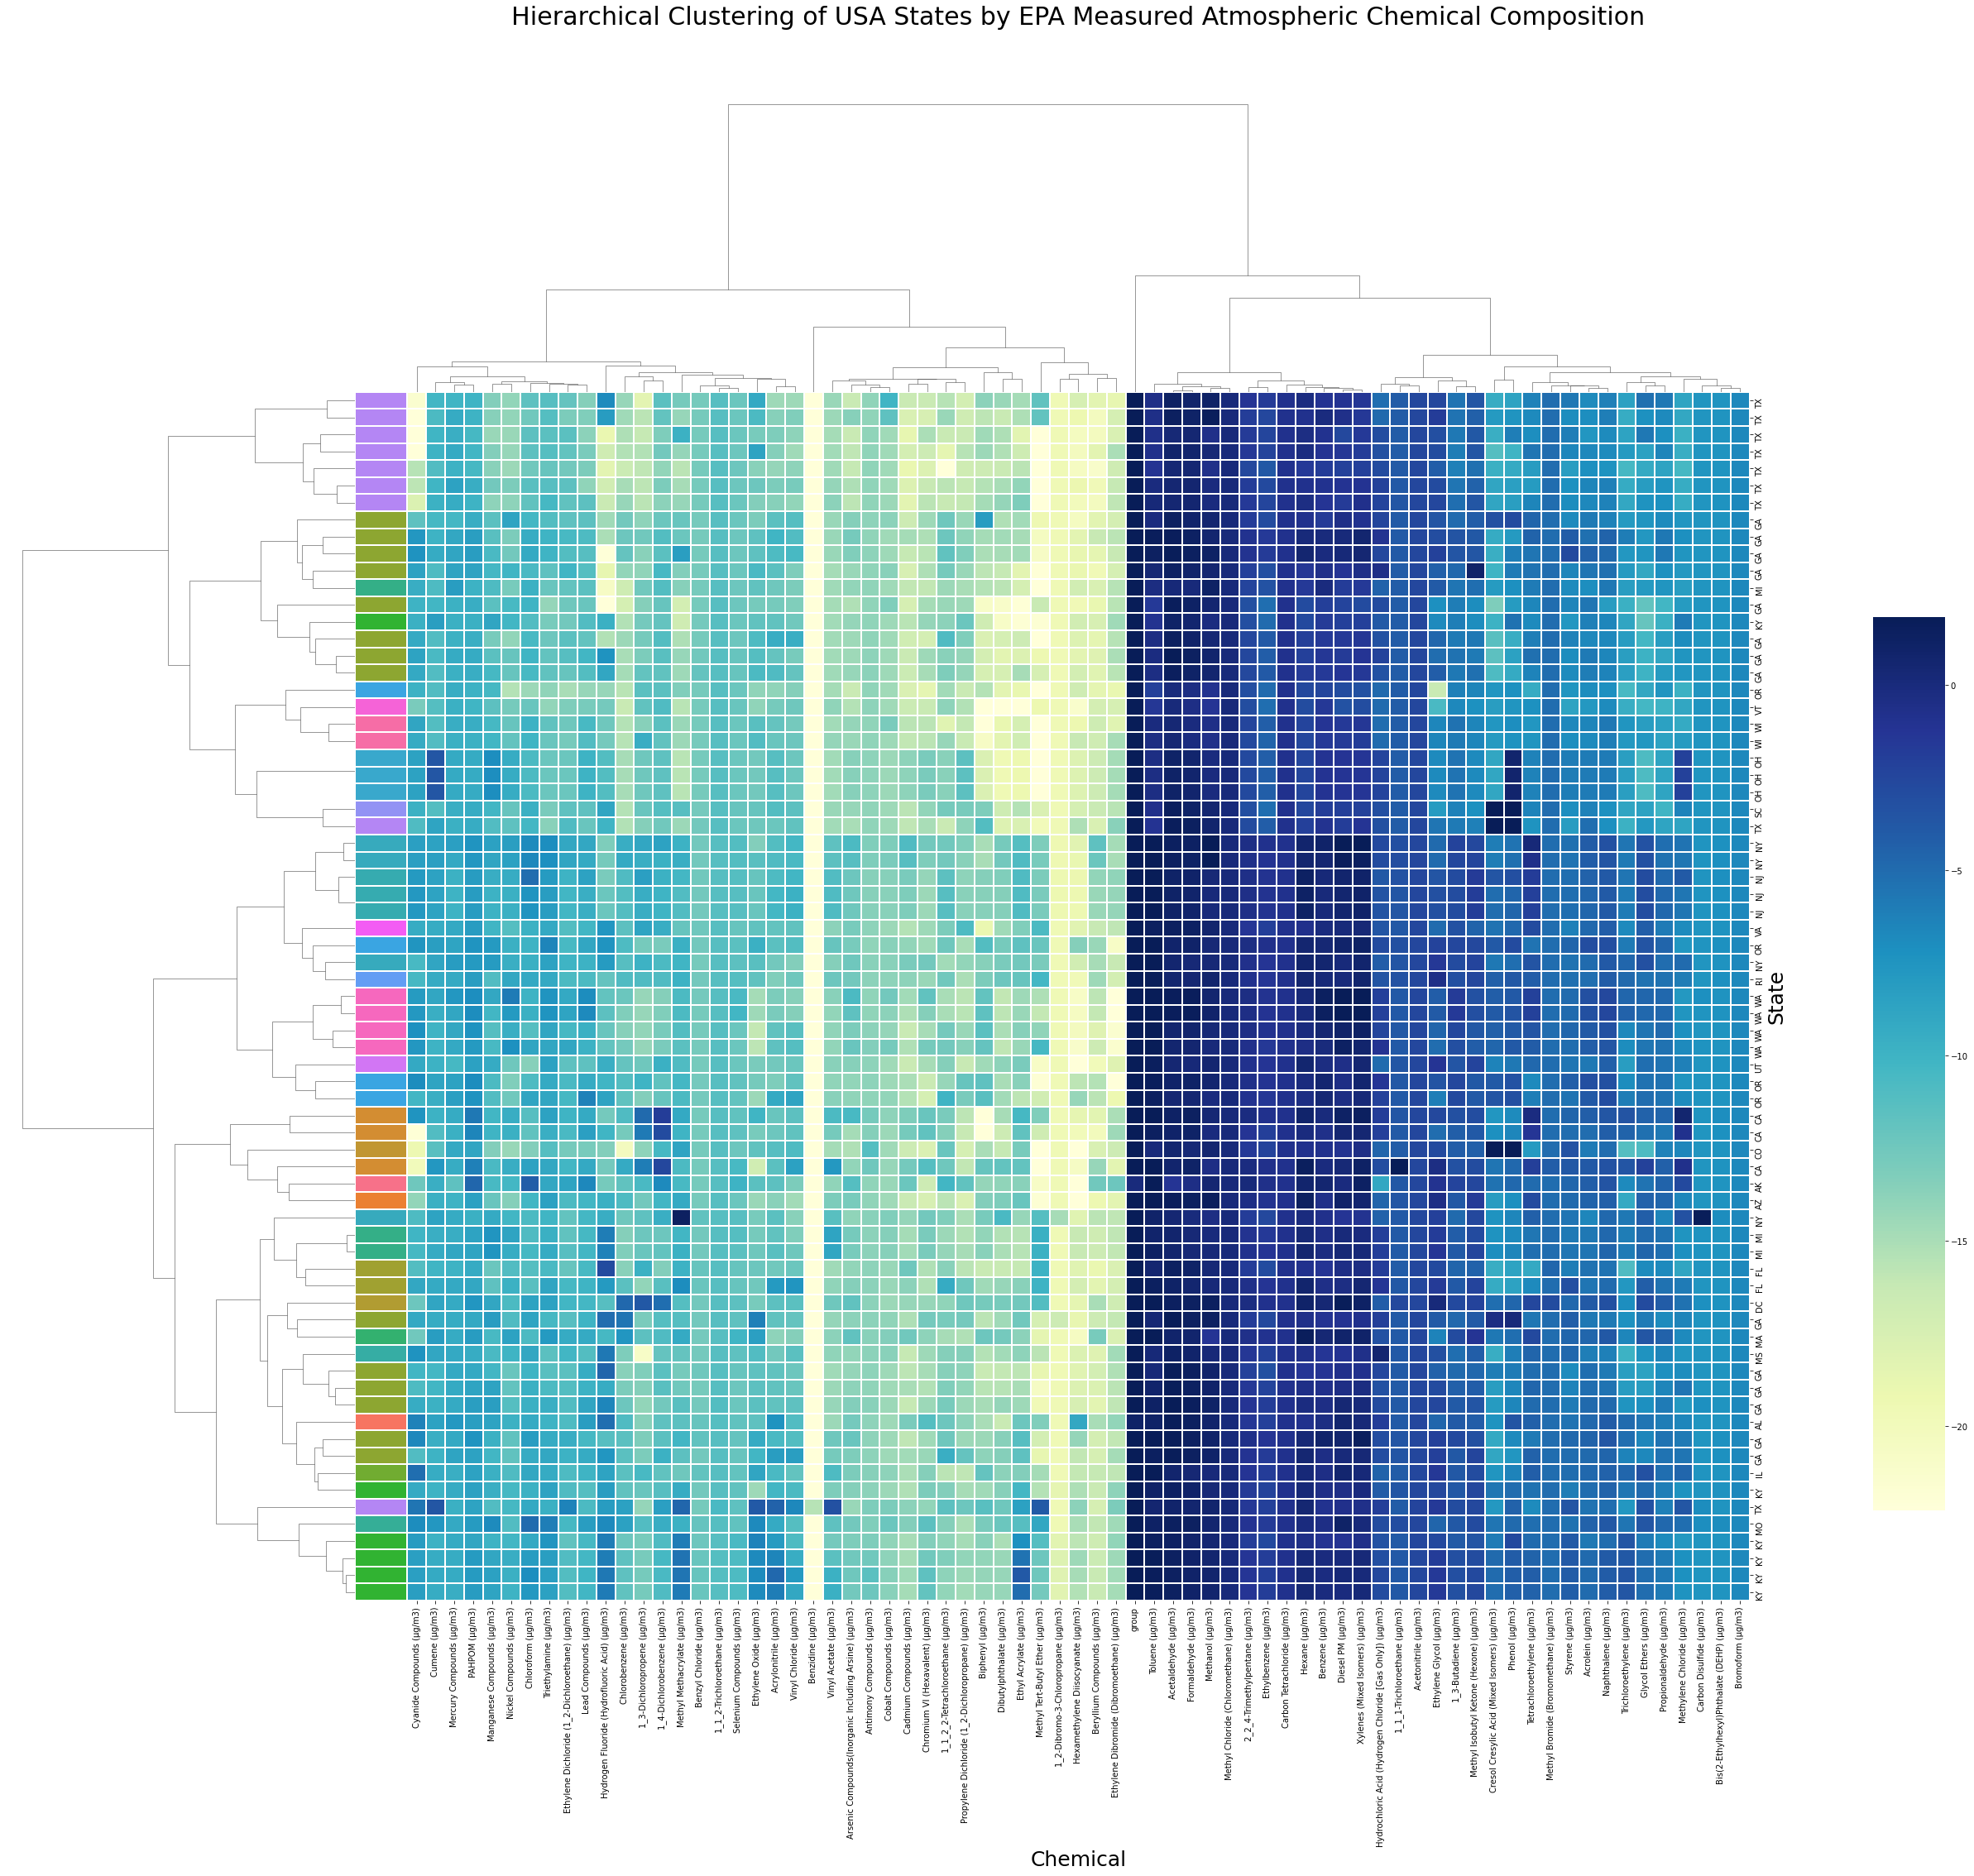

In [299]:
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl', len(dfidgroups.group.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(dfidgroups.group.unique(), network_pal))

#get the series of all of the categories
networks = dfidgroups.group

#map the colors to the series. Now we have a list of colors the same
#length as our dataframe, where unique values are mapped to the same color
network_colors = pd.Series(networks).map(network_lut)

#plot the heatmap with the 16S and ITS categories with the network colors
#defined by Source column
g = sns.clustermap(dfidgroups, method = 'ward', robust = True, figsize=(30,30), cmap = "YlGnBu", linewidths=0.1, cbar_pos=(1.05, .2, .04, .5), row_colors=[network_colors])
ax = g.ax_heatmap
ax.set_xlabel("Chemical", fontsize = 25)
ax.set_ylabel("State", fontsize = 25)
ax.set_title('Hierarchical Clustering of USA States by EPA Measured Atmospheric Chemical Composition', y=1.3, fontsize = 30)

In [284]:
data_clean.head(10)

STATE                                       AK         AL         AZ  \
index                                                                  
1_1_1-Trichloroethane (µg/m3)        -3.796887  -3.969953  -3.628549   
1_1_2-Trichloroethane (µg/m3)       -11.338465 -11.243084 -11.338482   
1_1_2_2-Tetrachloroethane (µg/m3)   -10.217871 -12.297899 -15.756331   
1_2-Dibromo-3-Chloropropane (µg/m3) -19.538592 -19.538592 -19.538592   
1_3-Butadiene (µg/m3)                -2.340012  -3.927546  -3.727048   
1_3-Dichloropropene (µg/m3)         -10.648289 -13.544534 -12.585733   
1_4-Dichlorobenzene (µg/m3)          -6.753184 -11.692039 -10.224865   
2_2_4-Trimethylpentane (µg/m3)        0.093651  -1.430071  -0.507488   
Acetaldehyde (µg/m3)                 -1.229480   1.711477   1.633853   
Acetonitrile (µg/m3)                 -2.556369  -2.556387  -2.556380   

STATE                                       CA         CA         CA  \
index                                                                  
1_1_1-Trichloroethane (µg/m3)        -3.691659  -3.958038   2.172166   
1_1_2-Trichloroethane (µg/m3)       -11.298838 -11.336614 -11.338501   
1_1_2_2-Tetrachloroethane (µg/m3)   -12.990007 -13.452792 -12.453104   
1_2-Dibromo-3-Chloropropane (µg/m3) -19.538592 -19.538592 -19.538592   
1_3-Butadiene (µg/m3)                -3.182316  -4.225048  -3.287228   
1_3-Dichloropropene (µg/m3)          -4.927887  -5.871919  -6.020687   
1_4-Dichlorobenzene (µg/m3)          -1.876380  -2.786328  -2.552992   
2_2_4-Trimethylpentane (µg/m3)       -0.163373  -1.221850  -0.171511   
Acetaldehyde (µg/m3)                  1.122677   0.922019   0.768978   
Acetonitrile (µg/m3)                 -2.556290  -2.556393  -2.548995   

STATE                                       CO         DC         FL  \
index                                                                  
1_1_1-Trichloroethane (µg/m3)        -4.058894  -2.643089  -4.008687   
1_1_2-Trichloroethane (µg/m3)       -11.335073 -11.336866 -11.338495   
1_1_2_2-Tetrachloroethane (µg/m3)   -12.102761 -13.958841 -13.680923   
1_2-Dibromo-3-Chloropropane (µg/m3) -19.538592 -19.538592 -19.538592   
1_3-Butadiene (µg/m3)                -4.146058  -2.756964  -4.644116   
1_3-Dichloropropene (µg/m3)         -13.833838  -3.733962  -9.750723   
1_4-Dichlorobenzene (µg/m3)         -10.435447  -5.172656 -13.320547   
2_2_4-Trimethylpentane (µg/m3)       -1.615615  -0.288660  -1.792319   
Acetaldehyde (µg/m3)                  0.676393   1.375001   1.351475   
Acetonitrile (µg/m3)                 -2.556393  -2.555287  -2.556389   

STATE                                       FL  ...         TX         UT  \
index                                           ...                         
1_1_1-Trichloroethane (µg/m3)        -3.798316  ...  -4.024433  -3.663098   
1_1_2-Trichloroethane (µg/m3)       -11.338500  ... -11.321190 -11.338465   
1_1_2_2-Tetrachloroethane (µg/m3)    -9.355322  ... -18.510574 -13.431661   
1_2-Dibromo-3-Chloropropane (µg/m3) -19.538592  ... -19.538592 -19.538592   
1_3-Butadiene (µg/m3)                -3.817412  ...  -6.044512  -3.611149   
1_3-Dichloropropene (µg/m3)         -14.067893  ... -15.323020 -12.459590   
1_4-Dichlorobenzene (µg/m3)         -11.409585  ... -12.603076  -9.734505   
2_2_4-Trimethylpentane (µg/m3)       -0.608884  ...  -1.503430  -0.829054   
Acetaldehyde (µg/m3)                  1.010048  ...   0.856128   0.442855   
Acetonitrile (µg/m3)                 -2.556393  ...  -2.556392  -2.556369   

STATE                                       VA         VT         WA  \
index                                                                  
1_1_1-Trichloroethane (µg/m3)        -3.729315  -4.058518  -3.867341   
1_1_2-Trichloroethane (µg/m3)       -11.333957 -11.338499 -11.337045   
1_1_2_2-Tetrachloroethane (µg/m3)   -13.117491 -13.841973 -14.953249   
1_2-Dibromo-3-Chloropropane (µg/m3) -19.538592 -19.538592 -19.538592   
1_3-Butadiene (µg/m3)                -3.245413  

In [287]:
CA = ['CA', 'CA.1', 'CA.2']
TX = ['TX', 'TX.1','TX.2', 'TX.3', 'TX.4', 'TX.5', 'TX.6', 'TX.7', 'TX.8']

In [288]:
CA_df = df2[CA]
TX_df = df2[TX]

In [289]:
CATX = TwoCategoryMaster(df2,TX_df,CA_df,"TX","CA")
CATX.head(10)

/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


AK         AL         AZ  \
index                                                                   
1_1_1-Trichloroethane (¬µg/m3)        -3.796887  -3.969953  -3.628549   
1_1_2-Trichloroethane (¬µg/m3)       -11.338465 -11.243084 -11.338482   
1_1_2_2-Tetrachloroethane (¬µg/m3)   -10.217871 -12.297899 -15.756331   
1_2-Dibromo-3-Chloropropane (¬µg/m3) -19.538592 -19.538592 -19.538592   
1_3-Butadiene (¬µg/m3)                -2.340012  -3.927546  -3.727048   
1_3-Dichloropropene (¬µg/m3)         -10.648289 -13.544534 -12.585733   
1_4-Dichlorobenzene (¬µg/m3)          -6.753184 -11.692039 -10.224865   
2_2_4-Trimethylpentane (¬µg/m3)        0.093651  -1.430071  -0.507488   
Acetaldehyde (¬µg/m3)                 -1.229480   1.711477   1.633853   
Acetonitrile (¬µg/m3)                 -2.556369  -2.556387  -2.556380   

                                             CA       CA.1       CA.2  \
index                                                                   
1_1_1-Trichloroethane (¬µg/m3)        -3.691659  -3.958038   2.172166   
1_1_2-Trichloroethane (¬µg/m3)       -11.298838 -11.336614 -11.338501   
1_1_2_2-Tetrachloroethane (¬µg/m3)   -12.990007 -13.452792 -12.453104   
1_2-Dibromo-3-Chloropropane (¬µg/m3) -19.538592 -19.538592 -19.538592   
1_3-Butadiene (¬µg/m3)                -3.182316  -4.225048  -3.287228   
1_3-Dichloropropene (¬µg/m3)          -4.927887  -5.871919  -6.020687   
1_4-Dichlorobenzene (¬µg/m3)          -1.876380  -2.786328  -2.552992   
2_2_4-Trimethylpentane (¬µg/m3)       -0.163373  -1.221850  -0.171511   
Acetaldehyde (¬µg/m3)                  1.122677   0.922019   0.768978   
Acetonitrile (¬µg/m3)                 -2.556290  -2.556393  -2.548995   

                                             CO         DC         FL  \
index                                                                   
1_1_1-Trichloroethane (¬µg/m3)        -4.058894  -2.643089  -4.008687   
1_1_2-Trichloroethane (¬µg/m3)       -11.335073 -11.336866 -11.338495   
1_1_2_2-Tetrachloroethane (¬µg/m3)   -12.102761 -13.958841 -13.680923   
1_2-Dibromo-3-Chloropropane (¬µg/m3) -19.538592 -19.538592 -19.538592   
1_3-Butadiene (¬µg/m3)                -4.146058  -2.756964  -4.644116   
1_3-Dichloropropene (¬µg/m3)         -13.833838  -3.733962  -9.750723   
1_4-Dichlorobenzene (¬µg/m3)         -10.435447  -5.172656 -13.320547   
2_2_4-Trimethylpentane (¬µg/m3)       -1.615615  -0.288660  -1.792319   
Acetaldehyde (¬µg/m3)                  0.676393   1.375001   1.351475   
Acetonitrile (¬µg/m3)                 -2.556393  -2.555287  -2.556389   

                                           FL.1  ...       WA.3         WI  \
index                                            ...                         
1_1_1-Trichloroethane (¬µg/m3)        -3.798316  ...  -3.871994  -4.037055   
1_1_2-Trichloroethane (¬µg/m3)       -11.338500  ... -11.337949 -11.338490   
1_1_2_2-Tetrachloroethane (¬µg/m3)    -9.355322  ... -12.617442 -18.138880   
1_2-Dibromo-3-Chloropropane (¬µg/m3) -19.538592  ... -19.538592 -19.538592   
1_3-Butadiene (¬µg/m3)                -3.817412  ...  -3.075451  -5.383198   
1_3-Dichloropropene (¬µg/m3)         -14.067893  ... -14.145221 -13.586153   
1_4-Dichlorobenzene (¬µg/m3)         -11.409585  ... -13.024263 -11.475933   
2_2_4-Trimethylpentane (¬µg/m3)       -0.608884  ...  -0.773034  -2.468366   
Acetaldehyde (¬µg/m3)                  1.010048  ...   0.616337   0.365015   
Acetonitrile (¬µg/m3)                 -2.556393  ...  -2.551768  -2.556386   

                                           WI.1  ttest_pvalue    TX Mean  \
index                                                                      
1_1_1-Trichloroethane (¬µg/m3)        -4.028913  3.966841e-01  -3.966088   
1_1_2-Trichloroethane (¬µg/m3)       -11.338292  3.577560e-01 -11.252226   
1_1_2_2-Tetrachloroethane (¬µg/m3)   -14.235909  1.053251e-02 -16.437510   
1_2-Dibromo-3-Chloropropane (¬µg/m3) -19.538592           NaN -19.538592   
1_3-Butadiene (¬µg/m3

In [290]:
CATXr = CATX.reset_index()
CATXr.head(10)

index         AK         AL         AZ  \
0        1_1_1-Trichloroethane (¬µg/m3)  -3.796887  -3.969953  -3.628549   
1        1_1_2-Trichloroethane (¬µg/m3) -11.338465 -11.243084 -11.338482   
2    1_1_2_2-Tetrachloroethane (¬µg/m3) -10.217871 -12.297899 -15.756331   
3  1_2-Dibromo-3-Chloropropane (¬µg/m3) -19.538592 -19.538592 -19.538592   
4                1_3-Butadiene (¬µg/m3)  -2.340012  -3.927546  -3.727048   
5          1_3-Dichloropropene (¬µg/m3) -10.648289 -13.544534 -12.585733   
6          1_4-Dichlorobenzene (¬µg/m3)  -6.753184 -11.692039 -10.224865   
7       2_2_4-Trimethylpentane (¬µg/m3)   0.093651  -1.430071  -0.507488   
8                 Acetaldehyde (¬µg/m3)  -1.229480   1.711477   1.633853   
9                 Acetonitrile (¬µg/m3)  -2.556369  -2.556387  -2.556380   

          CA       CA.1       CA.2         CO         DC         FL  ...  \
0  -3.691659  -3.958038   2.172166  -4.058894  -2.643089  -4.008687  ...   
1 -11.298838 -11.336614 -11.338501 -11.335073 -11.336866 -11.338495  ...   
2 -12.990007 -13.452792 -12.453104 -12.102761 -13.958841 -13.680923  ...   
3 -19.538592 -19.538592 -19.538592 -19.538592 -19.538592 -19.538592  ...   
4  -3.182316  -4.225048  -3.287228  -4.146058  -2.756964  -4.644116  ...   
5  -4.927887  -5.871919  -6.020687 -13.833838  -3.733962  -9.750723  ...   
6  -1.876380  -2.786328  -2.552992 -10.435447  -5.172656 -13.320547  ...   
7  -0.163373  -1.221850  -0.171511  -1.615615  -0.288660  -1.792319  ...   
8   1.122677   0.922019   0.768978   0.676393   1.375001   1.351475  ...   
9  -2.556290  -2.556393  -2.548995  -2.556393  -2.555287  -2.556389  ...   

        WA.3         WI       WI.1  ttest_pvalue    TX Mean    CA Mean  \
0  -3.871994  -4.037055  -4.028913  3.966841e-01  -3.966088  -1.825844   
1 -11.337949 -11.338490 -11.338292  3.577560e-01 -11.252226 -11.324651   
2 -12.617442 -18.138880 -14.235909  1.053251e-02 -16.437510 -12.965301   
3 -19.538592 -19.538592 -19.538592           NaN -19.538592 -19.538592   
4  -3.075451  -5.383198  -5.825888  7.184223e-03  -5.385482  -3.564864   
5 -14.145221 -13.586153  -9.488576  4.457965e-08 -15.622808  -5.606831   
6 -13.024263 -11.475933 -11.806463  1.978833e-08 -12.306924  -2.405233   
7  -0.773034  -2.468366  -2.687659  4.078521e-02  -1.849047  -0.518911   
8   0.616337   0.365015   0.337054  6.722514e-01   0.855005   0.937891   
9  -2.551768  -2.556386  -2.556384  4.133110e-01  -2.537420  -2.553893   

   Fold Change(TX/CA)  Log2(Fold Change)  -Log(P-value)  TX/CA pi score  
0            2.172195           1.119153       0.401555        0.449402  
1            0.993605          -0.009256       0.446413       -0.004132  
2            1.267808           0.342336       1.977468        0.676959  
3            1.000000           0.000000            NaN             NaN  
4            1.510712           0.595228       2.143620        1.275944  
5            2.786388           1.478396       7.350863       10.867489  
6            5.116728           2.355222       7.703591       18.143663  
7            3.563321           1.833222       1.389497        2.547258  
8            0.911625          -0.133488       0.172468       -0.023022  
9            0.993550          -0.009336       0.383723       -0.003582  

[10 rows x 79 columns]

In [291]:
CATXd = CATXr.dropna()
CATXd.head(10)

index         AK         AL         AZ  \
0       1_1_1-Trichloroethane (¬µg/m3)  -3.796887  -3.969953  -3.628549   
1       1_1_2-Trichloroethane (¬µg/m3) -11.338465 -11.243084 -11.338482   
2   1_1_2_2-Tetrachloroethane (¬µg/m3) -10.217871 -12.297899 -15.756331   
4               1_3-Butadiene (¬µg/m3)  -2.340012  -3.927546  -3.727048   
5         1_3-Dichloropropene (¬µg/m3) -10.648289 -13.544534 -12.585733   
6         1_4-Dichlorobenzene (¬µg/m3)  -6.753184 -11.692039 -10.224865   
7      2_2_4-Trimethylpentane (¬µg/m3)   0.093651  -1.430071  -0.507488   
8                Acetaldehyde (¬µg/m3)  -1.229480   1.711477   1.633853   
9                Acetonitrile (¬µg/m3)  -2.556369  -2.556387  -2.556380   
10                   Acrolein (¬µg/m3)  -4.277736  -4.755515  -4.513918   

           CA       CA.1       CA.2         CO         DC         FL  ...  \
0   -3.691659  -3.958038   2.172166  -4.058894  -2.643089  -4.008687  ...   
1  -11.298838 -11.336614 -11.338501 -11.335073 -11.336866 -11.338495  ...   
2  -12.990007 -13.452792 -12.453104 -12.102761 -13.958841 -13.680923  ...   
4   -3.182316  -4.225048  -3.287228  -4.146058  -2.756964  -4.644116  ...   
5   -4.927887  -5.871919  -6.020687 -13.833838  -3.733962  -9.750723  ...   
6   -1.876380  -2.786328  -2.552992 -10.435447  -5.172656 -13.320547  ...   
7   -0.163373  -1.221850  -0.171511  -1.615615  -0.288660  -1.792319  ...   
8    1.122677   0.922019   0.768978   0.676393   1.375001   1.351475  ...   
9   -2.556290  -2.556393  -2.548995  -2.556393  -2.555287  -2.556389  ...   
10  -4.264391  -5.056144  -3.887685  -5.887281  -3.952649  -5.328868  ...   

         WA.3         WI       WI.1  ttest_pvalue    TX Mean    CA Mean  \
0   -3.871994  -4.037055  -4.028913  3.966841e-01  -3.966088  -1.825844   
1  -11.337949 -11.338490 -11.338292  3.577560e-01 -11.252226 -11.324651   
2  -12.617442 -18.138880 -14.235909  1.053251e-02 -16.437510 -12.965301   
4   -3.075451  -5.383198  -5.825888  7.184223e-03  -5.385482  -3.564864   
5  -14.145221 -13.586153  -9.488576  4.457965e-08 -15.622808  -5.606831   
6  -13.024263 -11.475933 -11.806463  1.978833e-08 -12.306924  -2.405233   
7   -0.773034  -2.468366  -2.687659  4.078521e-02  -1.849047  -0.518911   
8    0.616337   0.365015   0.337054  6.722514e-01   0.855005   0.937891   
9   -2.551768  -2.556386  -2.556384  4.133110e-01  -2.537420  -2.553893   
10  -4.112907  -6.535110  -6.768420  5.035994e-03  -6.565005  -4.402740   

    Fold Change(TX/CA)  Log2(Fold Change)  -Log(P-value)  TX/CA pi score  
0             2.172195           1.119153       0.401555        0.449402  
1             0.993605          -0.009256       0.446413       -0.004132  
2             1.267808           0.342336       1.977468        0.676959  
4             1.510712           0.595228       2.143620        1.275944  
5             2.786388           1.478396       7.350863       10.867489  
6             5.116728           2.355222       7.703591       18.143663  
7             3.563321           1.833222       1.389497        2.547258  
8             0.911625          -0.133488       0.172468       -0.023022  
9             0.993550          -0.009336       0.383723       -0.003582  
10            1.491118           0.576395       2.297915        1.324506  

[10 rows x 79 columns]